<a href="https://colab.research.google.com/github/moncykurien/evaluation_projects/blob/main/Project10_AgricultureProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agriculture Project

This project is to determine the outcome of the harvest season, i.e. whether the crop would be healthy (alive), damaged by pesticides or damaged by other reasons.

## Data Description:

1. ID - Unique ID
2. Estimated_Insects_Count - Estimated Insects count per square meter
3. Crop_Type - Category of crop(0,1)
4. Soil_Type - Category of soil(0,1)
5. Pesticide_Use_Category - Type of Pesticides used(1 - Never, 2 - Previously Used, 3 - Currently Using)
6. Number_Doses_Week - Number of Doses per week
7. Number_Weeks_Used - Number of Weeks used
8. Number_Weeks_Quit - Number of Weeks quit
9. Season - Season Category (1,2,3)
10. Crop_Damage - Crop Damage category(Target Variable) (0 - Alive, 1 - Damage due to other causes, 2 - Damage due to Pesticides).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier 

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

import joblib

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('https://github.com/dsrscientist/Data-Science-ML-Capstone-Projects/blob/master/train_agriculture.xlsx?raw=true')
df = data.copy()

In [3]:
df.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [4]:
df.tail()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
4594,F00008078,2138,0,1,2,20,NaN,1,1,1
4595,F00008079,2139,0,1,2,30,47.0,2,1,1
4596,F00008080,2267,0,1,2,10,7.0,27,2,0
4597,F00008082,2267,0,1,2,10,20.0,24,2,0
4598,F00008083,2267,0,1,2,10,33.0,17,2,0


Observations:
1. There are some NaN values in Number_Weeks_Used.
2. ID variable consists of alphanumeric values.
3. Most of the variables seem to be discrete variables.

In [5]:
df.shape

(4599, 10)

Observations:
1. There are 4599 rows and 10 columns in the dataset.

In [6]:
print("Number of unique values in each variable:")
for col in df.columns:
  print(f"{col}: {df[col].nunique()}")

Number of unique values in each variable:
ID: 4599
Estimated_Insects_Count: 71
Crop_Type: 2
Soil_Type: 2
Pesticide_Use_Category: 3
Number_Doses_Week: 20
Number_Weeks_Used: 63
Number_Weeks_Quit: 47
Season: 3
Crop_Damage: 3


Observations:
1. The ID variable has unique variable for each record. 
2. The 'Estimated_Insects_Count', 'Number_Weeks_Used' and 'Number_Weeks_Quit' have many unique values 71, 63 and 47 respectively.
3. The 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season' and 'Crop_Damage' have only few categories 2, 2, 3, 3 and 3 respectively.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4599 entries, 0 to 4598
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       4599 non-null   object 
 1   Estimated_Insects_Count  4599 non-null   int64  
 2   Crop_Type                4599 non-null   int64  
 3   Soil_Type                4599 non-null   int64  
 4   Pesticide_Use_Category   4599 non-null   int64  
 5   Number_Doses_Week        4599 non-null   int64  
 6   Number_Weeks_Used        4157 non-null   float64
 7   Number_Weeks_Quit        4599 non-null   int64  
 8   Season                   4599 non-null   int64  
 9   Crop_Damage              4599 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 359.4+ KB


Observations:
1. There are 8 integer variables(discrete), one float variable and an object variable.

In [8]:
for col in df.drop(['ID'],axis=1).columns:
  print(f"Unique values in variable {col}: ")
  print(df[col].unique())
  print("="*50+"\n")

Unique values in variable Estimated_Insects_Count: 
[ 188  209  257  342  448  577  731 1132 1212 1575 1785 2138 2401 2999
 3516 3895 4096  150  151  168  232  231  256  283  312  311  375  411
  410  488  489  531  626  625  677  732  789  790  851  850  915  916
  984 1056 1296 1297 1385 1478 1576 1678 1786 1898 2015 2016 2139 2267
 2402 2542 2541 2688 2687 2840 3164 3165 3336 3337 3702 3896  169 3515
 4097]

Unique values in variable Crop_Type: 
[1 0]

Unique values in variable Soil_Type: 
[0 1]

Unique values in variable Pesticide_Use_Category: 
[1 3 2]

Unique values in variable Number_Doses_Week: 
[ 0 30 40 60 20 25 45 50 15 10  5 35 70 55 80 90 85 65 75 95]

Unique values in variable Number_Weeks_Used: 
[ 0. nan 26. 20. 15. 14. 19. 24.  8. 23. 25. 28. 29. 22. 21. 17. 30. 35.
 32. 27. 16. 31. 33. 34. 39. 38. 42. 40. 41. 36. 44. 37. 46. 45. 47. 43.
 50. 10. 49. 53. 48. 51. 54. 52. 55. 56. 61. 18. 57. 62. 60. 63. 66. 59.
 64. 13.  7.  5. 12.  6.  9. 58. 11. 65.]

Unique values in v

Observations:
1. Although 'Number_Weeks_Used' variable is a float variable, it contains only discrete values. It must be because there are nan values in this variab;e.
2. There are 3 classes in the target variable 'Crop_Damage'. This is a multiclass classification problem.

### Statistical Description

In [9]:
df.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4157.000000,4599.000000,4599.000000,4599.000000
mean,1363.000435,0.224831,0.476625,2.283540,26.477495,28.891027,9.205479,1.894325,0.194390
std,814.439120,0.417517,0.499508,0.471978,15.524647,12.586005,9.713253,0.694952,0.454597
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1786.000000,0.000000,1.000000,3.000000,40.000000,38.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,66.000000,47.000000,3.000000,2.000000


Observations:
1. 'Estimated_Insect_Count' ranges from 150 to 4097. The distribution is right skewed.
2. At least 75% or more of the records belong to Crop_Type 0.
3. At least 50% or more of the records belong to Soil_Type 0.
4. At least 25% of the records in Pesticide_Use_Category are 2's and another 25% of the categories are 3's.
5. Number_Doses_Week ranges from 0 to 95. The distribution is right skewed.
6. Number_Weeks_Used ranges from 0 to 66. Close to normal distribution.
7. Number_Weeks_Quit ranges from 0 to 47. The distribution is right skewed.
8. The Season variable has 1,2 and 3 categories. At least 25% of the records belong to category 1 and another 25% of the records belong to category 2.
9. In the target variable 'Crop_Damage', at least 75% of the records belong to category '0'. 

In [10]:
pd.set_option('display.max_columns',df.shape[1])
pd.set_option('display.max_rows', df.shape[0])

In [11]:
df.isnull().sum()

ID                           0
Estimated_Insects_Count      0
Crop_Type                    0
Soil_Type                    0
Pesticide_Use_Category       0
Number_Doses_Week            0
Number_Weeks_Used          442
Number_Weeks_Quit            0
Season                       0
Crop_Damage                  0
dtype: int64

Observations:
1. There are 442 missing values in Number_Weeks_Used

## Data Cleaning

### Handling Missing values

#### Missing values in 'Number_Weeks_Used' variable

In [12]:
print(f"The most used values in 'Number_Weeks_Used' is {df['Number_Weeks_Used'].mode()[0]}")

The most used values in 'Number_Weeks_Used' is 20.0


Note:
1. The most used values in 'Number_Weeks_Used' is 20.0
2. We can either fill the nans with the most used value 20 or use some other eay to impute the missing value.
3. Using mode will increase the dominance of the value 20 by adding another 442 '20's in the variable.
4. The Number of Weeks a pesticide should be Used may depend on other factors also like the 'Estimated_Insects_Count'(number of insects per sq meter), 'Crop_Type', 'Soil_Type' and also the 'Pesticide_Use_Category'. I will consider all these rows while imputing the missing values.

In [13]:
#getting the most used values in 'Number_Weeks_Used' variable based of other variables
num_week_used = df[~df['Number_Weeks_Used'].isnull()].groupby(['Estimated_Insects_Count','Pesticide_Use_Category','Crop_Type','Soil_Type'])[['Number_Weeks_Used']].agg(lambda x: x.value_counts().index[0])
num_week_used.head(10)

Number_Weeks_Used
Estimated_Insects_Count Pesticide_Use_Category Crop_Type Soil_Type                   
150                     2                      0         1                       18.0
                                               1         0                       20.0
                        3                      0         0                       24.0
                                                         1                       24.0
                                               1         0                       19.0
                                                         1                       13.0
151                     2                      0         1                       12.0
                        3                      0         0                       20.0
                                                         1                       21.0
                                               1         0                       15.0

Observations:
1. As expected there are different modes in each groups. Ill be considering this variation while imputing the missing values.

In [14]:
indexes = np.where(df['Number_Weeks_Used'].isnull())
print(f"There are {len(indexes[0])} missing values in 'Number_Weeks_Used' variable.")

There are 442 missing values in 'Number_Weeks_Used' variable.


In [15]:
#Custum method to imputed missing values in Number_Weeks_Used
def custom_imputer(x):
  try: 
    return num_week_used.loc[x.Estimated_Insects_Count,x.Pesticide_Use_Category,x.Crop_Type,x.Soil_Type].values[0] 
  except: 
    return 20  #if there is not values returning the mode of Number_Weeks_Used variable.

In [16]:
#Making a new copy of the dataframe.
df_new = df.copy()

#Missing values imputed
df_new.loc[indexes[0], 'Number_Weeks_Used'] = df.iloc[indexes[0]][['Estimated_Insects_Count','Pesticide_Use_Category','Crop_Type','Soil_Type']].apply(lambda x: custom_imputer(x), axis=1)

In [17]:
df_new.isnull().sum()

ID                         0
Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
dtype: int64

Observations:
1. The missing values are filled with most used values based on each group.

Verifying a few values added in the place of missing values.

In [18]:
df_new[df['Number_Weeks_Used'].isnull()].head(10)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
5,F00000008,448,0,1,1,0,20.0,0,2,1
6,F00000009,448,0,1,1,0,20.0,0,2,1
10,F00000021,1212,1,0,1,0,20.0,0,3,0
17,F00000037,2401,0,1,1,0,20.0,0,1,1
35,F00000076,257,0,0,3,30,32.0,0,2,0
51,F00000105,411,0,0,3,30,30.0,0,2,0
59,F00000121,448,0,0,3,10,28.0,0,2,1
60,F00000122,448,0,0,3,30,28.0,0,3,1
65,F00000127,448,0,1,3,45,31.0,0,2,0
80,F00000154,531,0,0,3,20,35.0,0,1,0


#### Verifying how filling missing values has impacted the Number_Weeks_Used variable

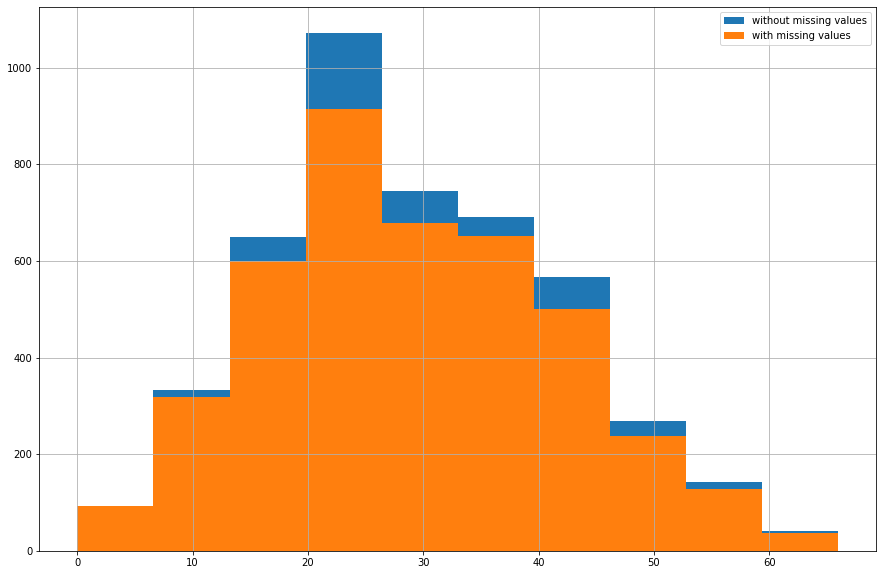

In [19]:
df_new['Number_Weeks_Used'].hist(figsize=(15,10))
df['Number_Weeks_Used'].hist()
plt.legend(['without missing values','with missing values'])


Observations:
1. We can see that the missing value imputation has increased the frequency of  a range of values and not just the frequency of the mode(20).

## Exploratory Data Analysis

#### Univariate Analysis

In [20]:
for col in df_new.drop(['ID'],axis=1).columns:
  if df_new[col].nunique() < 30:
    print(f"Values counts for column {col}:")
    print(df_new[col].value_counts())
    print('='*50+"\n")

Values counts for column Crop_Type:
0    3565
1    1034
Name: Crop_Type, dtype: int64

Values counts for column Soil_Type:
0    2407
1    2192
Name: Soil_Type, dtype: int64

Values counts for column Pesticide_Use_Category:
2    3205
3    1349
1      45
Name: Pesticide_Use_Category, dtype: int64

Values counts for column Number_Doses_Week:
20    1211
40     657
30     584
10     537
15     393
5      268
25     263
60     237
50     172
35     101
45      53
0       45
80      36
70      17
55      11
90       5
85       4
65       3
75       1
95       1
Name: Number_Doses_Week, dtype: int64

Values counts for column Season:
2    2327
1    1379
3     893
Name: Season, dtype: int64

Values counts for column Crop_Damage:
0    3820
1     664
2     115
Name: Crop_Damage, dtype: int64



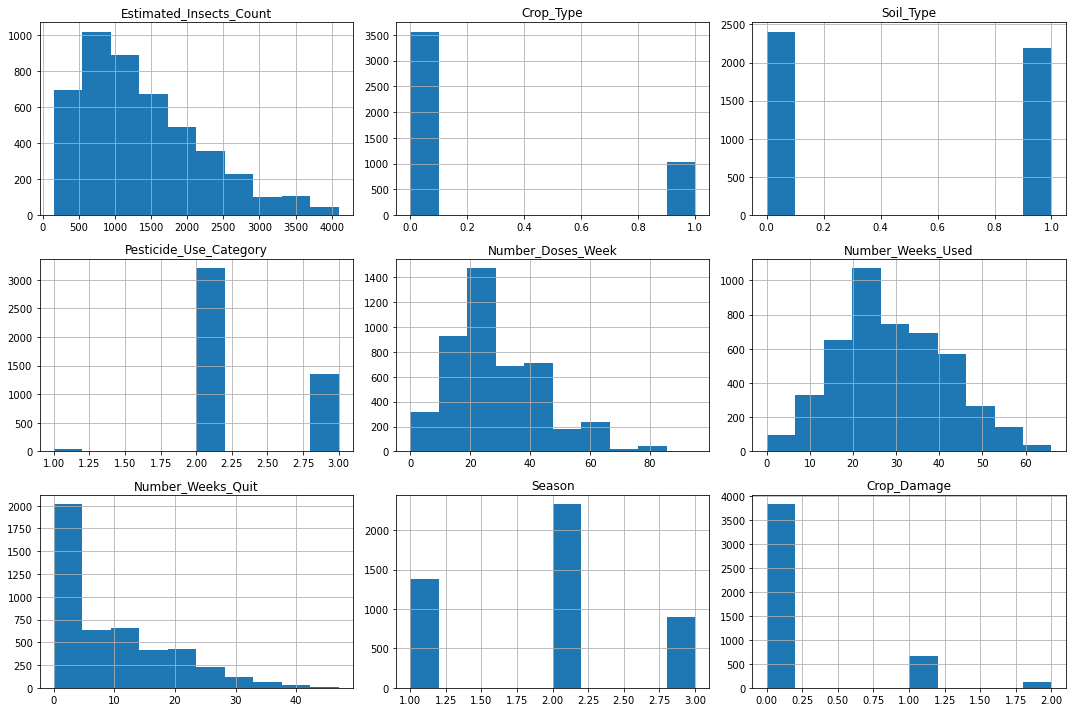

In [21]:
df_new.hist(figsize=(15,10))
plt.tight_layout()

Observations:
1. The Estimated_Insects_Count, Number_Doses_Week and Number_Weeks_Quit show positing skewness.
2. Number_Weeks_Used shows a slight skew.
3. There are approximately 3.5 times data in Crop_Type = 0 than in Crop_Type=1 in this dataset.
4. The Soil_Type 0 and 1 are almost equally distributed in the dataset.
5. The occurance of category 1 in Pesticide_Use_Category is very low in the dataset.Category 2 is the most occuring category in the dataset.
6. The most frequent category in 'Season' variable is '2' and the most least is '3'
7. The Crop_Damage(target) variable is imbalanced. The category 0 is dominating. The least frequent category is 2. This is an imbalanced classification problem.

### Multi Variate Analysis

In [22]:
def show_distribution(data, col, func, fig_size = (15,7)):
    if func == 'count':
        plt.figure(figsize=fig_size)
        plt.title(f"Frequency of {col}")
        sns.countplot(data[col], hue = data['Crop_Damage'])
        plt.show()
    elif func == 'dist':
        plt.figure(figsize=fig_size)     
        plt.title(f"Distribution on {col}")
        
        plt.axvline(np.mean(data[data['Crop_Damage']==0][col]), color='b', linestyle='--')
        plt.axvline(np.mean(data[data['Crop_Damage']==1][col]), color='y', linestyle='--')        
        plt.axvline(np.mean(data[data['Crop_Damage']==2][col]), color='g', linestyle='--')        
        
        sns.distplot(data[data['Crop_Damage']==0][col], hist=False, color='b',)
        sns.distplot(data[data['Crop_Damage']==1][col], hist=False, color='y')
        sns.distplot(data[data['Crop_Damage']==2][col], hist=False, color='g')

        plt.legend([0,1,2])
        plt.show()


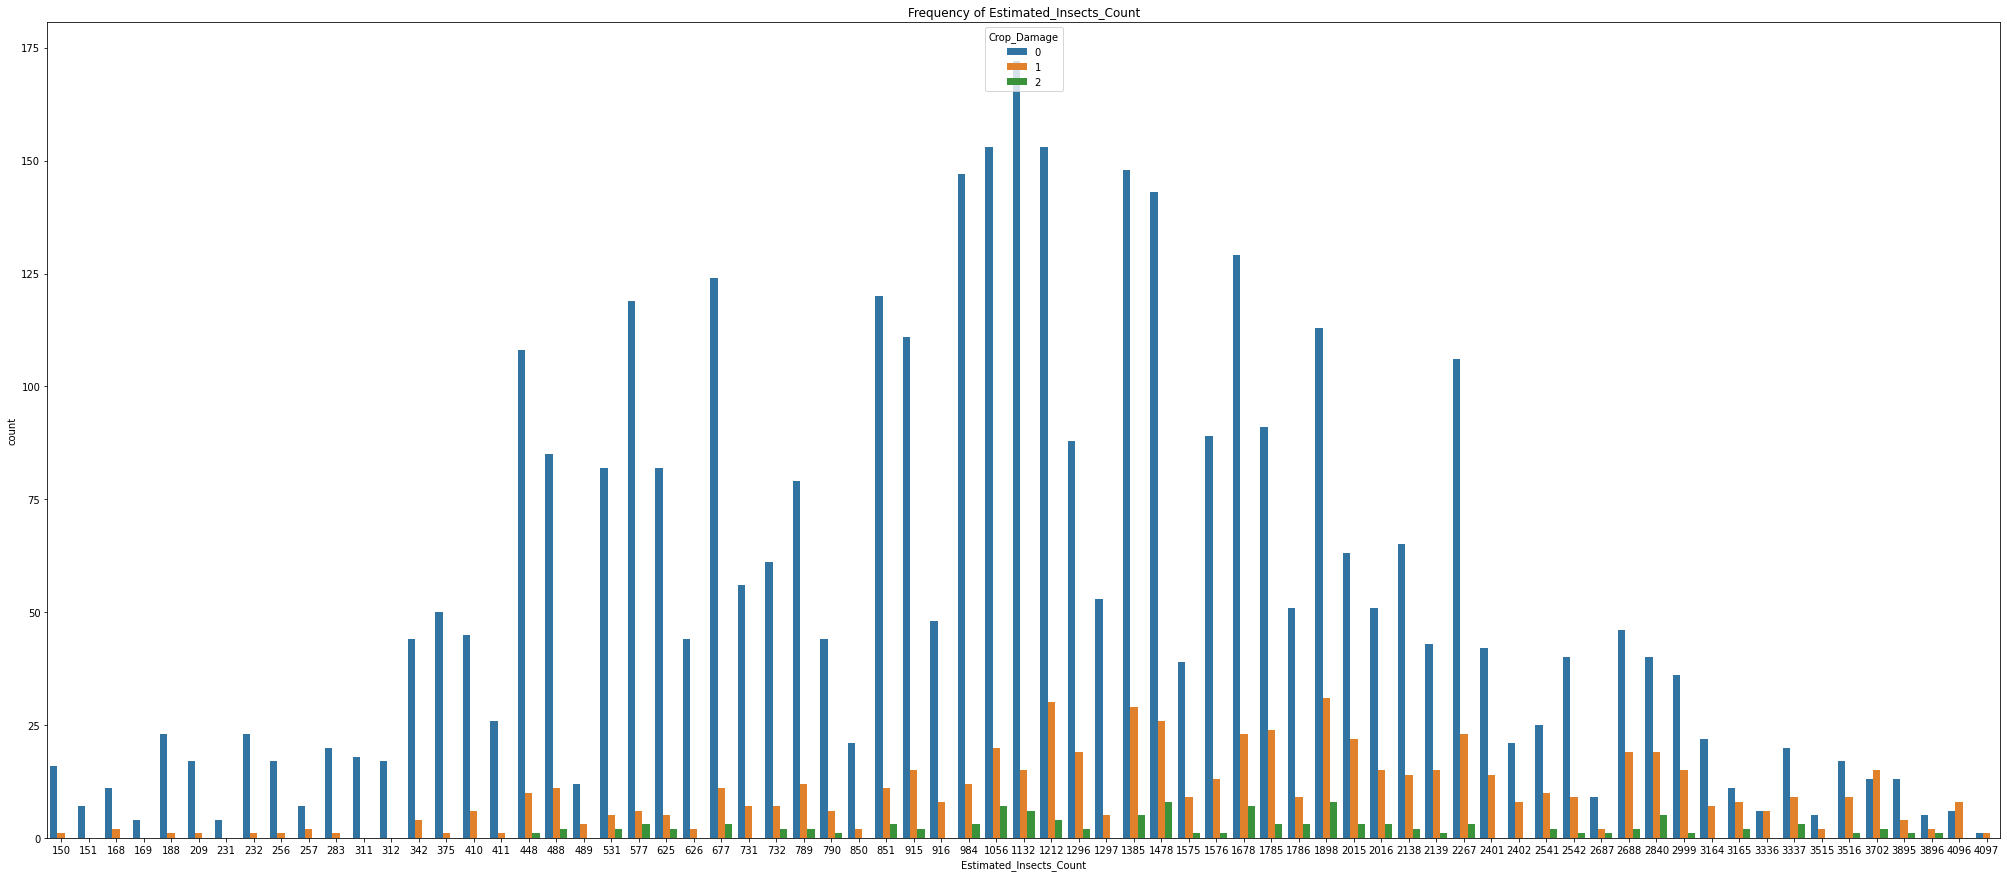

In [23]:
show_distribution(df_new, 'Estimated_Insects_Count','count', (35,15))

Observations:
1. Most of the values in the mid range of Estimated_Insects_Count variable have all three categories of target variable(Crop_Damage) however, the category '2' of Crop_Damage are very less in this dataset.

Estimated_Insects_Count

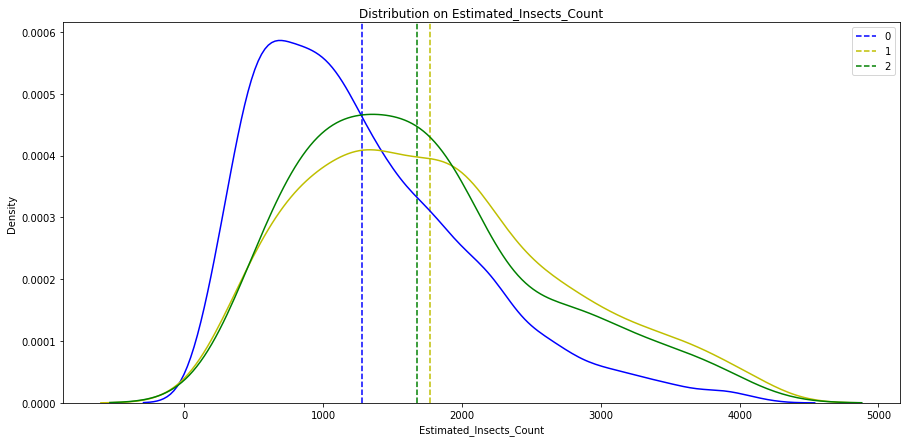

In [24]:
show_distribution(df_new, 'Estimated_Insects_Count','dist')

Observations:
1. The category 0 is well classified.
2. Categories 1 and 2 are not distinguished clearly by Estimated_Insects_Count.

Crop_Type

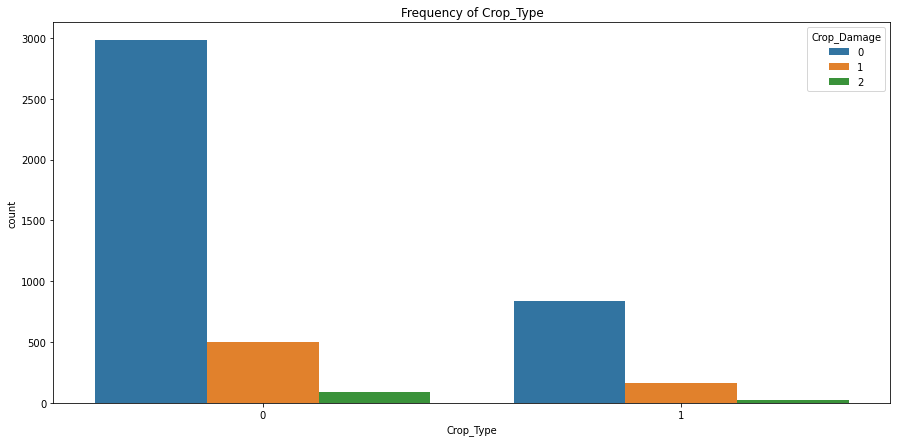

In [25]:
show_distribution(df_new, 'Crop_Type','count')

Observations:
1. Both Crop_Types(0,1) have all three catagories of Crop_Damage. But category 2 is very very low.

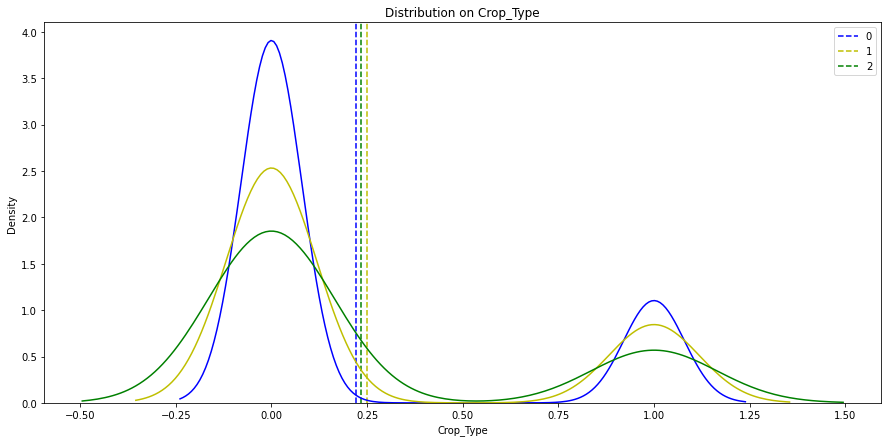

In [26]:
show_distribution(df_new, 'Crop_Type',"dist")

Observations:
1. Crop_Type is not able to distinguish between the categories of Crop_Damage variable.

Soil_Type

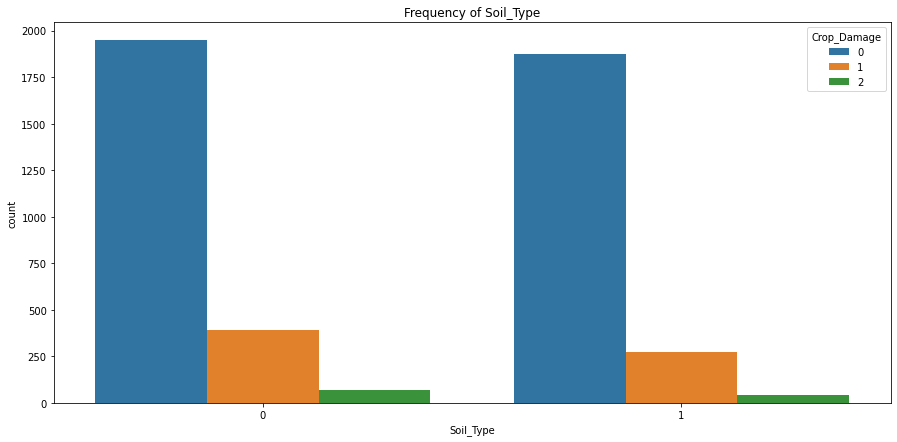

In [27]:
show_distribution(df_new, 'Soil_Type','count')

Observations:
1. All the Crop_Damage categories samples are available for Soil_Type 0 and 1. But Crop_Damage = 2 is very less.

Pesticide_Use_Category

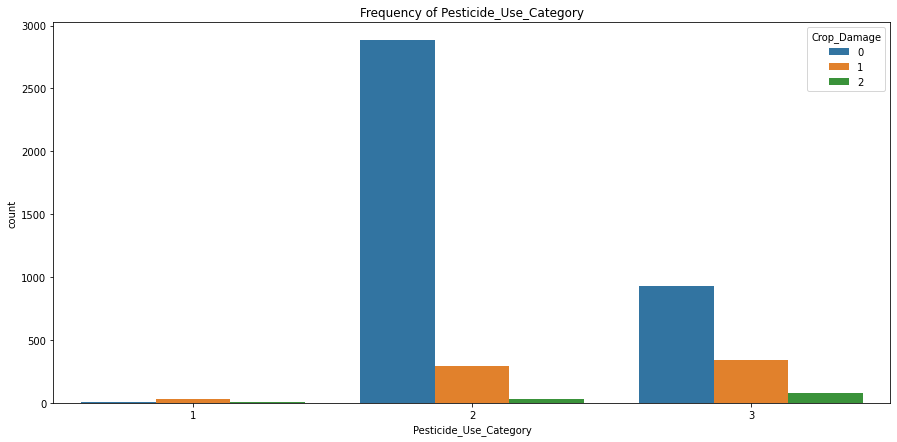

In [29]:
show_distribution(df_new, 'Pesticide_Use_Category','count')

Observations:
1. The sample for Pesticide_use_Category = 1 is very less.

Pesticide_Use_Category + Number_Weeks_Used vs Crop_Damage

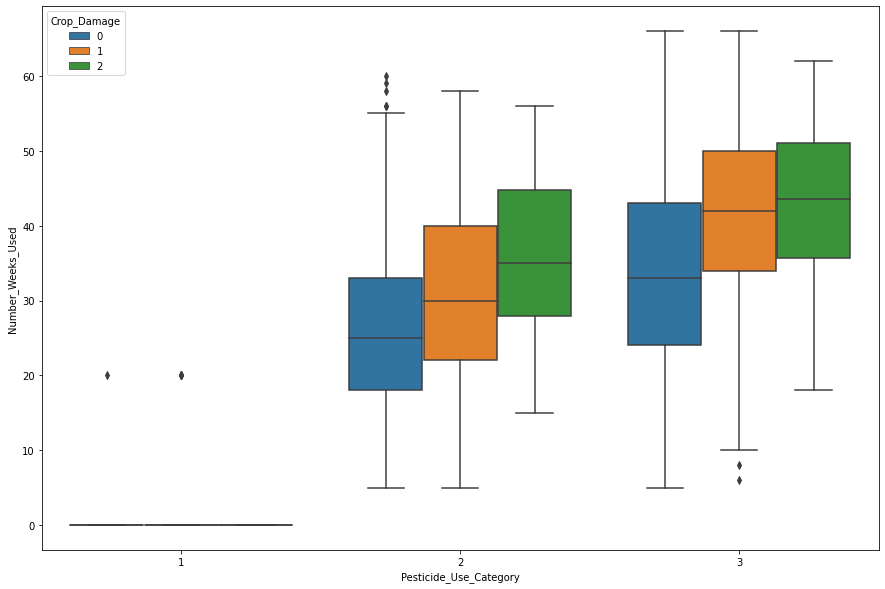

In [31]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pesticide_Use_Category', y= 'Number_Weeks_Used', hue='Crop_Damage' ,data=df_new)
plt.show()

Observations:
1. Longer the number of weeks the pesticides are used or were used in the past, the higher the change of Crop being damaged by pesticides.

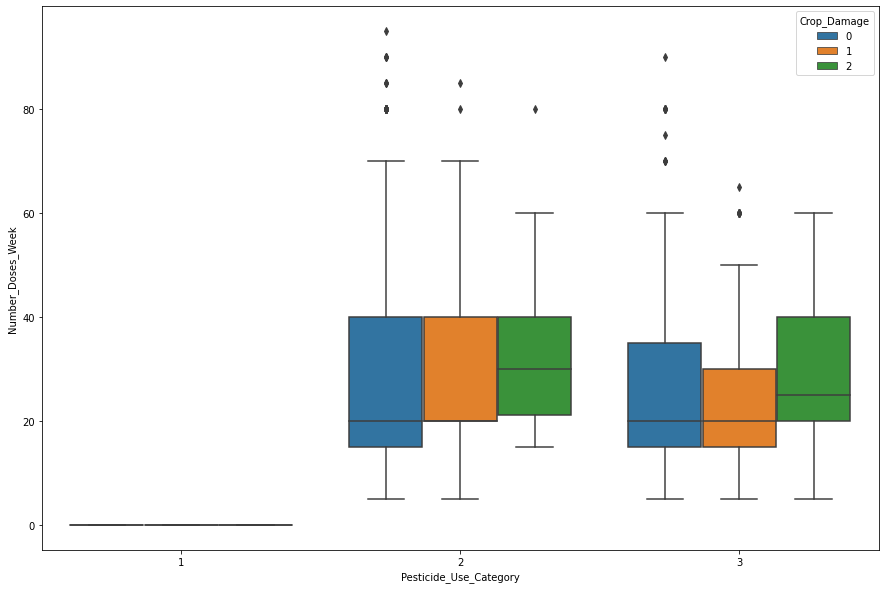

In [32]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pesticide_Use_Category', y= 'Number_Doses_Week', hue='Crop_Damage' ,data=df_new)
plt.show()

Observations:
1. If Pesticides are currently being used, the chance of Crop damage by pesticides can be lowered by lowering the number of doses per week to lesser than approximately 35.

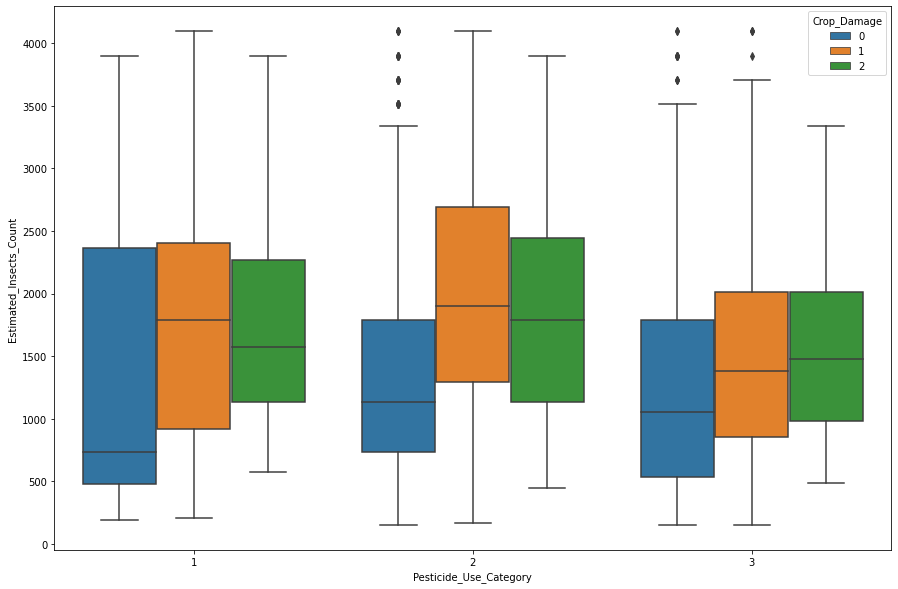

In [33]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pesticide_Use_Category', y= 'Estimated_Insects_Count', hue='Crop_Damage' ,data=df_new)
plt.show()

Observations:
1. Using pesticides currently can reduce the Insects count.

In [34]:
def show_multivar_dist(data, feature_list, target, share_axis_scale = False, hist = False, kde = True):
  plt.figure(figsize=(20,8))
  plt.suptitle(f'Multivariate distribution plot for "{target}" variable')
  j = 1
  axs = plt.subplot(1,3,3)
  for i in data[target].unique():
    if share_axis_scale:
      plt.subplot(1,3,j,sharex=axs,sharey=axs)
    else:
      plt.subplot(1,3,j)
    
    for col in feature_list:      
      sns.distplot(data[data[target]==i][col], hist=hist, kde=kde)
    
    plt.xlabel(i)
    plt.legend(feature_list)
    j+=1


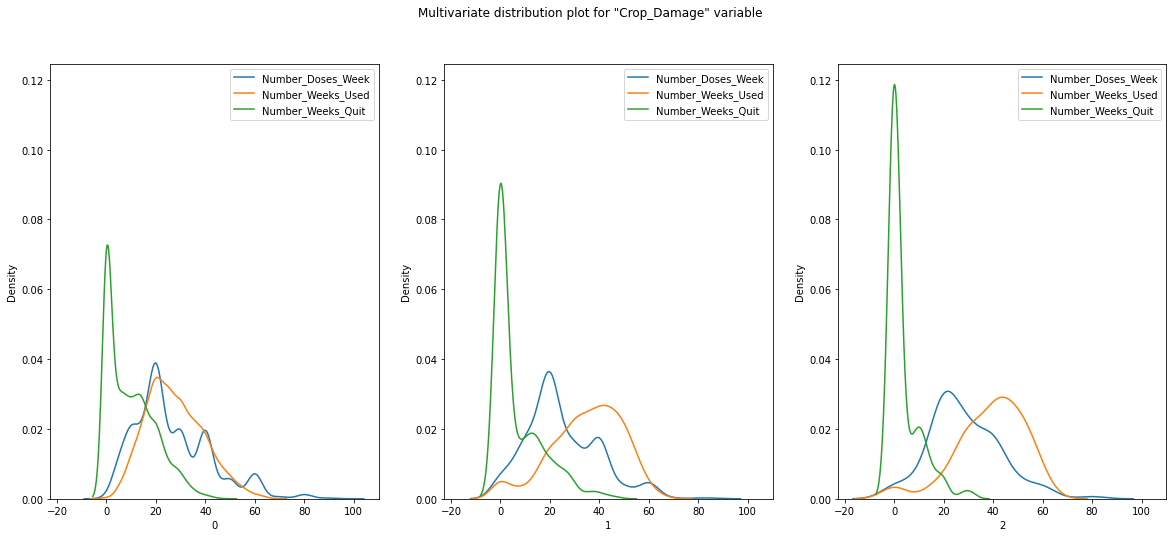

In [35]:
show_multivar_dist(df_new, [ 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit'], 'Crop_Damage', True)

Observations:
1. The Number_Doses_Week, Number_Weeks_Used adn Number_Weeks_Quit can be combined to distinguish between the three categories of Crop_Damage variable.

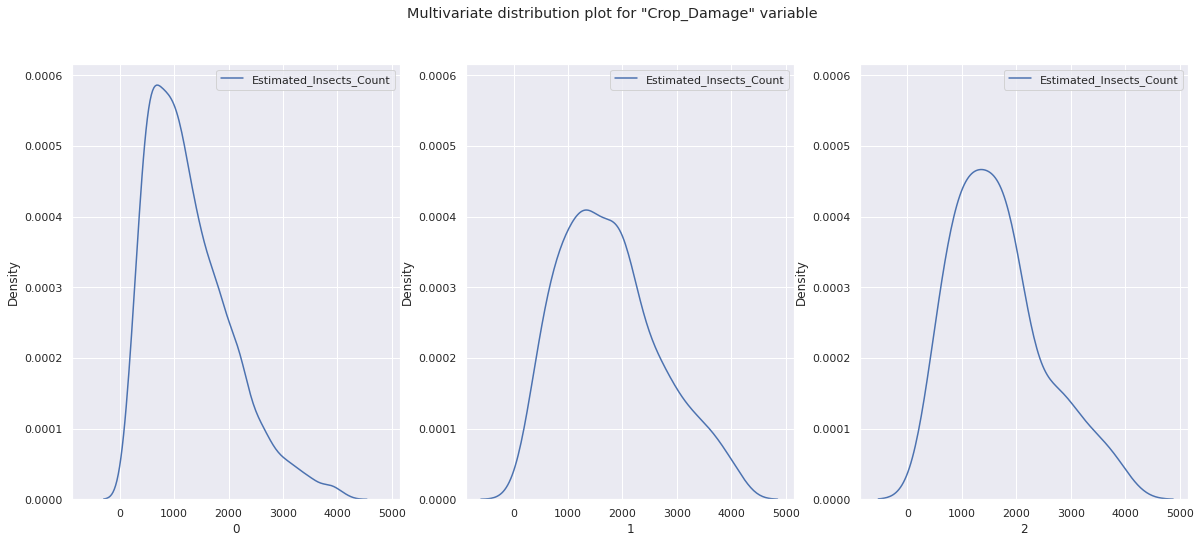

In [ ]:
show_multivar_dist(df_new, [ 'Estimated_Insects_Count'], 'Crop_Damage', True)

## Outliers

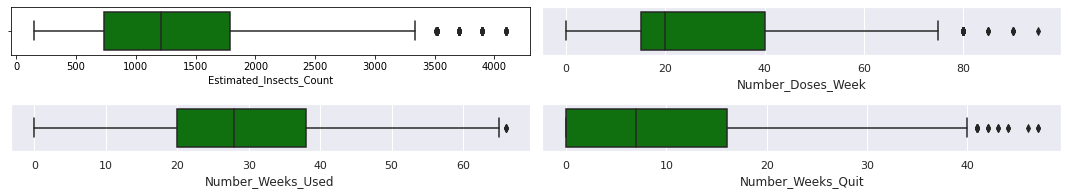

In [ ]:
columns = ['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Used','Number_Weeks_Quit']

plt.figure(figsize=(15, 40))
for i in range(0,len(columns)):
  plt.subplot(30,2,i+1)
  sns.set(font_scale = 1)
  sns.boxplot(df_new[columns[i]], color='green')
  plt.tight_layout()


Observations:
1. There are some outliers in the dataset.

In [ ]:
zf = np.abs(zscore(df_new.drop(['ID'], axis=1)))

In [ ]:
threshold = 3
df_no_out = df_new[(zf < threshold).all(axis=1)]
print(f"{round((df_new.shape[0] - df_no_out.shape[0])/ df_new.shape[0]*100)}% data removed as outliers.")

5% data removed as outliers.


In [ ]:
df_new.shape

(4599, 10)

In [ ]:
df_new[['Crop_Damage']].value_counts()

Crop_Damage
0              3820
1               664
2               115
dtype: int64

In [ ]:
115/4599

0.025005435964340073

In [ ]:
df_no_out['Crop_Damage'].unique()

array([0, 1])

Observations:
1. Even though only 5% of data is removed as outliers, it includes the Category 2 in the target variable "Crop_Damage". So its not a good idea to remove the outliers in this case.

In [ ]:
x = df_new.drop(['ID','Crop_Damage'], axis=1)
y = df_new['Crop_Damage']

In [ ]:
x.head()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,188,1,0,1,0,0.0,0,1
1,209,1,0,1,0,0.0,0,2
2,257,1,0,1,0,0.0,0,2
3,257,1,1,1,0,0.0,0,2
4,342,1,0,1,0,0.0,0,2


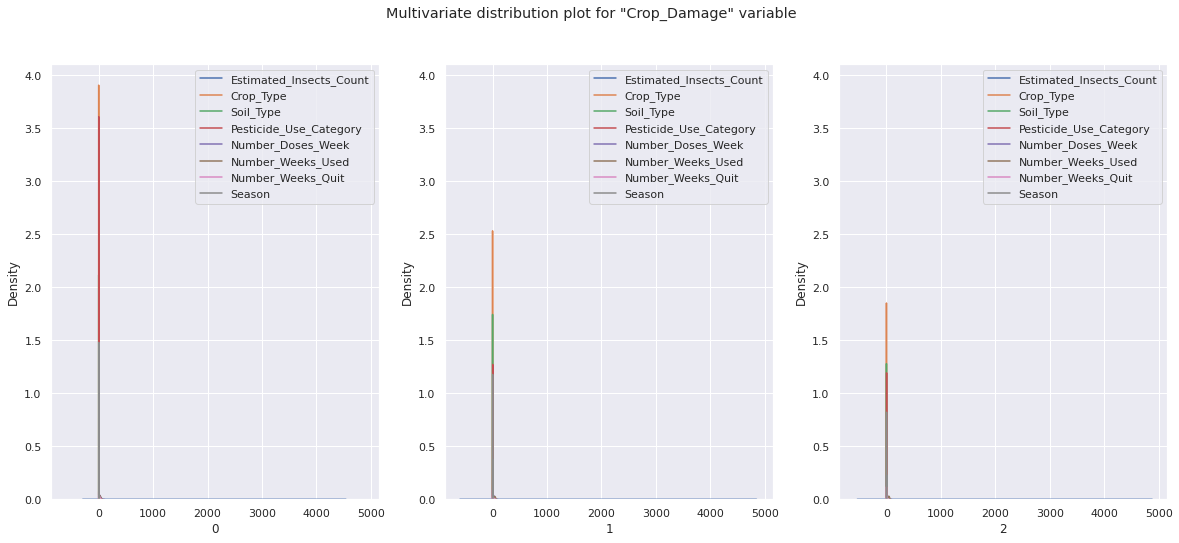

In [ ]:
show_multivar_dist(df_new, ['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season'], 'Crop_Damage', True)

Observations:
1. We can see that the variables are not in the same scale hence not distinguishable.

PowerTransform

In [ ]:
df_new.skew()

Estimated_Insects_Count    0.911469
Crop_Type                  1.318693
Soil_Type                  0.093631
Pesticide_Use_Category     0.678586
Number_Doses_Week          0.945895
Number_Weeks_Used          0.286831
Number_Weeks_Quit          0.919771
Season                     0.144841
Crop_Damage                2.306933
dtype: float64

Observations:
1. The Estimated_Insects_Count, Number_Doses_Week, Number_Weeks_Quit are skewed.

In [ ]:
pt = PowerTransformer()
x_pt = x.copy()
x_pt[['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Quit']] = pt.fit_transform(x[['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Quit']])

In [ ]:
#x_df_pt = pd.DataFrame(x_pt, columns=[['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Quit']])
x_pt.tail()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
4594,1.003197,0,1,2,-0.279016,19.0,-0.788394,1
4595,1.004073,0,1,2,0.381917,47.0,-0.504125,1
4596,1.114021,0,1,2,-1.160435,7.0,1.368852,2
4597,1.114021,0,1,2,-1.160435,20.0,1.259832,2
4598,1.114021,0,1,2,-1.160435,33.0,0.952946,2


In [ ]:
temp_df=pd.concat([pd.DataFrame(x_pt, columns=df_no_out.drop(['ID','Crop_Damage'],axis=1).columns.values),pd.DataFrame(y,columns=['Crop_Damage'])], axis=1)

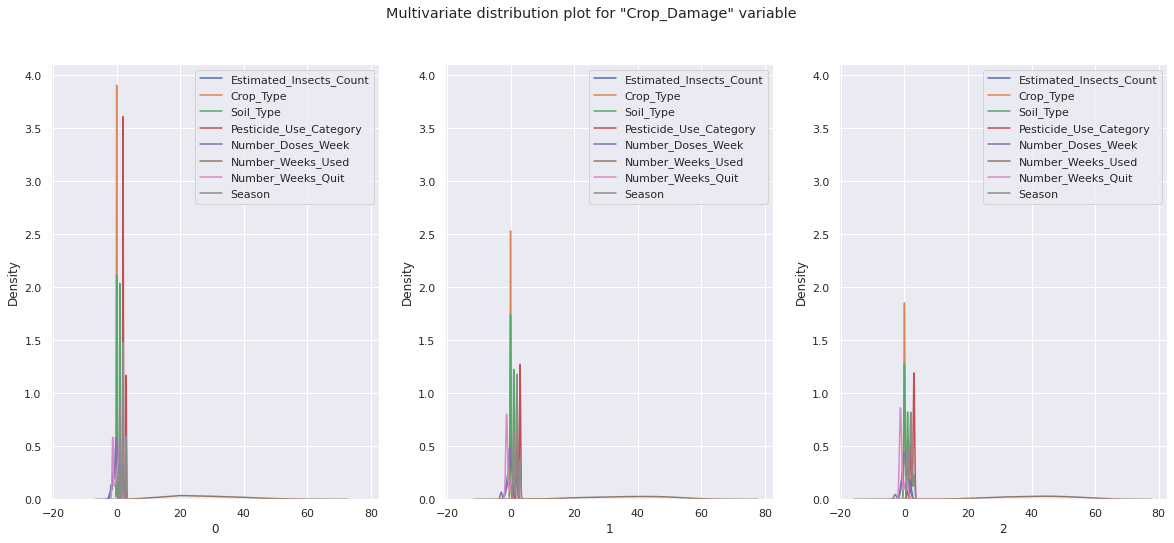

In [ ]:
show_multivar_dist(temp_df, ['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season'], 'Crop_Damage', True)

Observations:
1. The power transformation has provided some characteristics for the features.

In [ ]:
x_pt.skew()

Estimated_Insects_Count   -0.032846
Crop_Type                  1.318693
Soil_Type                  0.093631
Pesticide_Use_Category     0.678586
Number_Doses_Week          0.008110
Number_Weeks_Used          0.286831
Number_Weeks_Quit         -0.089868
Season                     0.144841
dtype: float64

Observations:
1. The skewness had decreased considerably.

Scaling Date using MinMaxScaler

In [ ]:
mn = MinMaxScaler(feature_range=(0,1))
x_pt_mn = x_pt.copy()
x_pt_mn = mn.fit_transform(x_pt_mn)
x_pt_mn = pd.DataFrame(x_pt_mn, columns=x_pt.columns.values)
x_pt_mn.tail()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
4594,0.719303,0.0,1.0,0.5,0.443367,0.287879,0.143408,0.0
4595,0.719486,0.0,1.0,0.5,0.553617,0.712121,0.233633,0.0
4596,0.742431,0.0,1.0,0.5,0.296339,0.106061,0.828101,0.5
4597,0.742431,0.0,1.0,0.5,0.296339,0.303030,0.793499,0.5
4598,0.742431,0.0,1.0,0.5,0.296339,0.500000,0.696096,0.5


In [ ]:
temp_df=pd.concat([pd.DataFrame(x_pt_mn, columns=df_no_out.drop(['ID','Crop_Damage'],axis=1).columns.values),pd.DataFrame(y,columns=['Crop_Damage'])], axis=1)

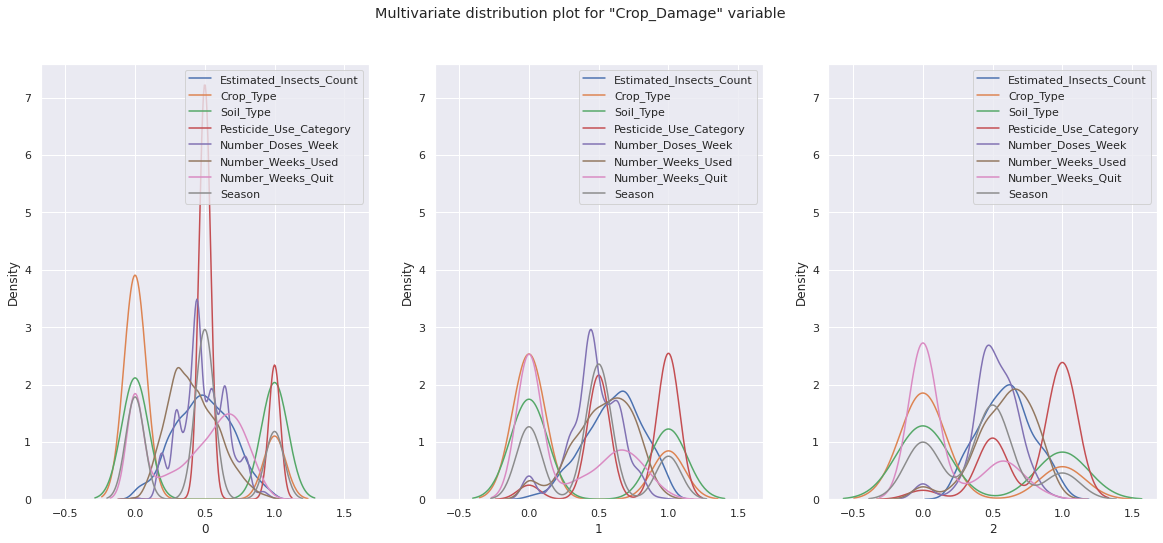

In [ ]:
show_multivar_dist(temp_df, ['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season'], 'Crop_Damage', True)

Observations:
1. Now that the features are scaled, we can see a clear disctinction in the target classes using the features.

## Finding the Random State

In [ ]:
r_state = 0
train_score = 0
test_score = 0

for i in range(0,101):
  x_tr, x_ts, y_tr, y_ts = train_test_split(x_pt_mn, y, test_size = 0.3, random_state = i, stratify = y)
  model = LogisticRegression(class_weight='balanced')
  model.fit(x_tr, y_tr)
  y_tr_pred = model.predict(x_tr)
  y_ts_pred = model.predict(x_ts)
  tr_score = f1_score(y_tr, y_tr_pred, average = 'weighted')
  ts_score = f1_score(y_ts, y_ts_pred, average = 'weighted')
  if ts_score > test_score:
    if round(tr_score,2) == round(ts_score,2):
      train_score = tr_score
      test_score = ts_score
      r_state = i

print(f"random state: {r_state}, Train score: {train_score}, test score: {test_score}")
print(f"Variance: {round(train_score - test_score,6)}")
    


random state: 92, Train score: 0.6861398388929729, test score: 0.6901381901653237
Variance: -0.003998


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pt_mn, y, test_size = 0.3, random_state = 92, stratify = y)

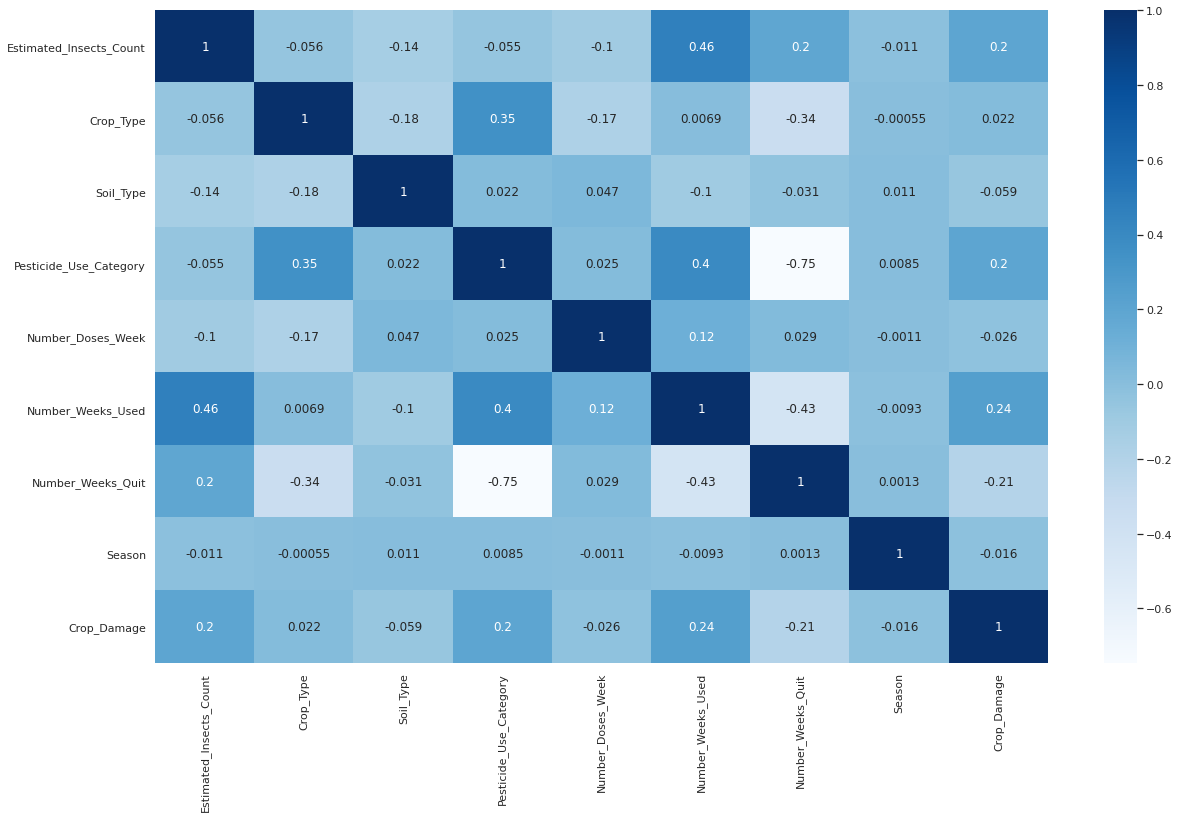

In [ ]:
plt.figure(figsize=(20,12))
corr = pd.concat([pd.DataFrame(x_pt_mn, columns=df_no_out.drop(['ID','Crop_Damage'],axis=1).columns.values),pd.DataFrame(y,columns=['Crop_Damage'])], axis=1).corr()
sns.heatmap(corr,cmap='Blues', annot=True)

Observations:
1. The correlation of the target variable is spread across all the independent variables.

In [ ]:
models = [LogisticRegression(class_weight='balanced'), SVC(class_weight='balanced'), DecisionTreeClassifier(class_weight='balanced'), KNeighborsClassifier(weights='distance')]

for model in models:

  cv_model = cross_val_score(model, x_train, y_train, scoring = 'f1_weighted', cv=10, n_jobs= -1)
  
  print(f"Model: {model.__class__.__name__}")
  print(f"Cross val score: {cv_model}")
  print(f"Mean Cross val score: {cv_model.mean()}")
  print(f"Variance: {cv_model.var()}")
  print("="*50)


Model: LogisticRegression
Cross val score: [0.68152129 0.68396169 0.69402449 0.66642668 0.70352691 0.67262327
 0.67679017 0.66196146 0.70110746 0.69085643]
Mean Cross val score: 0.6832799841590351
Variance: 0.0001798357918263261
Model: SVC
Cross val score: [0.68590087 0.65978281 0.72640095 0.65073364 0.69907684 0.67334593
 0.696465   0.66528931 0.70862529 0.68430903]
Mean Cross val score: 0.6849929661556864
Variance: 0.0004937503357057948
Model: DecisionTreeClassifier
Cross val score: [0.74388642 0.76886985 0.73047761 0.74351757 0.74344738 0.75652626
 0.68654265 0.74411121 0.74856542 0.76108678]
Mean Cross val score: 0.7427031147441668
Variance: 0.000455616385169484
Model: KNeighborsClassifier
Cross val score: [0.78587591 0.76080399 0.77492891 0.75775633 0.79242629 0.76470885
 0.76979838 0.77548182 0.78745416 0.78214361]
Mean Cross val score: 0.7751378237359312
Variance: 0.00012599810144980878


In [ ]:
models = [XGBClassifier(objective='multi:softmax'), DecisionTreeClassifier(class_weight='balanced'), KNeighborsClassifier(weights='distance'), RandomForestClassifier(class_weight='balanced',random_state=0), GradientBoostingClassifier(random_state=0), AdaBoostClassifier(n_estimators=100, random_state=0)]

for model in models:

  cv_model = cross_val_score(model, x_train, y_train, scoring = 'f1_weighted', cv=10, n_jobs= -1)
  
  print(f"Model: {model.__class__.__name__} ||  Mean Cross val score: {cv_model.mean()} || Variance: {cv_model.var()}")
  print("="*50)


Model: XGBClassifier ||  Mean Cross val score: 0.7763672373755685 || Variance: 8.419637504466964e-05
Model: DecisionTreeClassifier ||  Mean Cross val score: 0.7407302208647766 || Variance: 0.0002452393246805116
Model: KNeighborsClassifier ||  Mean Cross val score: 0.7751378237359312 || Variance: 0.00012599810144980878
Model: RandomForestClassifier ||  Mean Cross val score: 0.7780395708998448 || Variance: 0.00014509285721263837
Model: GradientBoostingClassifier ||  Mean Cross val score: 0.7761412320436716 || Variance: 9.494799568394744e-05
Model: AdaBoostClassifier ||  Mean Cross val score: 0.7770796222643732 || Variance: 9.982559923242265e-05


### Hyper Parameter Tuning

Hypertune GradientBoosClassifier

In [ ]:
learning_rate = [1,0.5,0.1, 0.06]
criterion = ['mse','friedman_mse']
max_depth   = [int(x) for x in np.linspace(10,110,11)]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
max_features = [None, 'auto','log2']

params = {'learning_rate':learning_rate,
          'criterion':criterion,
          'max_depth': max_depth,
          'n_estimators': n_estimators,
          'max_features':max_features}



gbc_model = GradientBoostingClassifier()

gbc_randomcv = RandomizedSearchCV(gbc_model, param_distributions=params, scoring = 'f1_weighted', cv = 10, random_state=0, verbose=10, n_iter=40, n_jobs=-1)
gbc_randomcv.fit(x_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 45

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                   

In [ ]:
print(gbc_randomcv.best_score_)
print(gbc_randomcv.best_params_)

0.7741242029614954
{'n_estimators': 1240, 'max_features': None, 'max_depth': 20, 'learning_rate': 0.5, 'criterion': 'friedman_mse'}


Hypertune AdaBoostClassifier

In [ ]:

learning_rate = [0.09,0.1,0.5,1]
algorithm = ['SAMME', 'SAMME.R']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]



params = {'learning_rate':learning_rate,
          'algorithm':algorithm,
          'n_estimators': n_estimators}



ada_model = AdaBoostClassifier()

ada_randomcv = RandomizedSearchCV(ada_model, param_distributions=params, scoring = 'f1_weighted', cv = 10, random_state=0, verbose=10, n_jobs=-1, n_iter=40)
ada_randomcv.fit(x_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  5

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.09, 0.1, 0.5, 1],
                                        'n_estimators': [100, 290, 480, 670,
                                                         860, 1050, 1240, 1430,
                                                         1620, 1810, 2000]},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring='f1_weighted', verbose=10)

In [ ]:
print(ada_randomcv.best_score_)
print(ada_randomcv.best_params_)

0.7860125792510566
{'n_estimators': 480, 'learning_rate': 1, 'algorithm': 'SAMME.R'}


Hypertune RandomForestClassifier

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
criterion = ['gini','entropy']
max_depth   = [int(x) for x in np.linspace(10,110,11)]
max_features = [None,'auto','log2']

params = {
    'n_estimators' : n_estimators,
    'criterion' : criterion,
    'max_depth' : max_depth,
    'max_features' : max_features
}


rand_model = RandomForestClassifier(class_weight = 'balanced_subsample', n_jobs = -1)

rand_randomcv = RandomizedSearchCV(rand_model, param_distributions = params, scoring = 'f1_weighted', cv = 10, random_state = 0, verbose=10, n_iter = 40)
rand_randomcv.fit(x_train, y_train)

Hidden the output because there were too many lines of details for the above cell.

In [ ]:
print(rand_randomcv.best_score_)
print(rand_randomcv.best_params_)

0.782913672985188
{'n_estimators': 100, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}


Hypertune XGBoostClassifier

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
learning_rate = [0.09,0.1,0.5,1]
booster = ['gbtree','dart']

params = {
    'n_estimators' : n_estimators,
    'learning_rate' : learning_rate,
    'booster' : booster
}


xgb_model = XGBClassifier(objective = 'multi:softmax')

xgb_randomcv = RandomizedSearchCV(xgb_model, param_distributions = params, scoring = 'f1_weighted', cv = 10, random_state = 0, verbose=10, n_iter = 10, n_jobs=-1)
xgb_randomcv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 59.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 75.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 75.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 77.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 77.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 115.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 172.2min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sca...eight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecat

In [ ]:
print(xgb_randomcv.best_score_)
print(xgb_randomcv.best_params_)

0.787658829356322
{'n_estimators': 480, 'learning_rate': 0.1, 'booster': 'gbtree'}


Hypertune GaussianNB

In [ ]:
var_smoothing = np.logspace(0,-9, num=100)

params = {
    'var_smoothing':var_smoothing
}

gnb = GaussianNB ()


gnb_randomcv = RandomizedSearchCV(gnb, param_distributions=params, scoring = 'f1_weighted', cv = 10, random_state=0, verbose=10, n_jobs=-1, n_iter=40)
gnb_randomcv.fit(x_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0448s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0659s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0821s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1503s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.4s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.0000000...
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring='f1_weighted', verbose=10)

In [ ]:
print(gnb_randomcv.best_score_)
print(gnb_randomcv.best_params_)

0.7863999360244902
{'var_smoothing': 0.006579332246575682}


Observations:
1. GradientBoostClassifier - 0.7741242029614954 - 
{'n_estimators': 1240, 'max_features': None, 'max_depth': 20, 'learning_rate': 0.5, 'criterion': 'friedman_mse'}
2. AdaBoostClassifier - 0.7860125792510566 - 
{'n_estimators': 480, 'learning_rate': 1, 'algorithm': 'SAMME.R'}
3. RandomForestClassifier - 0.782913672985188 - 
{'n_estimators': 100, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}
4. XGBoostClassifier - 0.787658829356322 - 
{'n_estimators': 480, 'learning_rate': 0.1, 'booster': 'gbtree'}
5. GaussianNB - 0.7863999360244902 - 
{'var_smoothing': 0.006579332246575682}

## Final Model

In [ ]:
gbc_model = GradientBoostingClassifier(n_estimators = 1240, max_features = None, max_depth = 20, learning_rate = 0.5, criterion = 'friedman_mse')
gbc_model.fit(x_train, y_train)
y_train_preds_gbc = gbc_model.predict(x_train)
y_train_preds_proba_gbc = gbc_model.predict_proba(x_train)

y_test_preds_gbc = gbc_model.predict(x_test)
y_test_preds_proba_gbc = gbc_model.predict_proba(x_test)

print("Gradient Boost Results:")
print("Training Score:")
print(f"Trainset F1 score: {f1_score(y_train, y_train_preds_gbc, average='weighted')}")
print(f"Trainset Roc Auc Score: {roc_auc_score(y_train, y_train_preds_proba_gbc, multi_class='ovo')}")
print(f"Trainset Confusion Matrix:\n {confusion_matrix(y_train, y_train_preds_gbc)}")
print(f"Trainser Classification Report:\n {classification_report(y_train,y_train_preds_gbc)}")
print("="*50)
print("Testing Score:")
print(f"Testset F1 score: {f1_score(y_test, y_test_preds_gbc, average='weighted')}")
print(f"Testset Roc Auc Score: {roc_auc_score(y_test, y_test_preds_proba_gbc, multi_class='ovo')}")
print(f"Testset Confusion Matrix:\n {confusion_matrix(y_test, y_test_preds_gbc)}")
print(f"Testset Classification Report:\n {classification_report(y_test,y_test_preds_gbc)}")

Gradient Boost Results:
Training Score:
Trainset F1 score: 0.9965763099996325
Trainset Roc Auc Score: 0.9976828489798216
Trainset Confusion Matrix:
 [[2673    0    1]
 [   8  455    2]
 [   0    0   80]]
Trainser Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       1.00      0.98      0.99       465
           2       0.96      1.00      0.98        80

    accuracy                           1.00      3219
   macro avg       0.99      0.99      0.99      3219
weighted avg       1.00      1.00      1.00      3219

Testing Score:
Testset F1 score: 0.7728729120170259
Testset Roc Auc Score: 0.6450145788361737
Testset Confusion Matrix:
 [[1053   76   17]
 [ 149   41    9]
 [  27    8    0]]
Testset Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1146
           1       0.33      0.21      0.25       199
           

In [ ]:
ada_model = AdaBoostClassifier(n_estimators = 480, learning_rate = 1, algorithm = 'SAMME.R')
ada_model.fit(x_train, y_train)
y_train_preds_ada = ada_model.predict(x_train)
y_train_preds_proba_ada = ada_model.predict_proba(x_train)

y_test_preds_ada = ada_model.predict(x_test)
y_test_preds_proba_ada = ada_model.predict_proba(x_test)

print("Ada Boost Results:")
print("Training Score:")
print(f"Trainset F1 score: {f1_score(y_train, y_train_preds_ada, average='weighted')}")
print(f"Trainset Roc Auc Score: {roc_auc_score(y_train, y_train_preds_proba_ada, multi_class='ovo')}")
print(f"Trainset Confusion Matrix:\n {confusion_matrix(y_train, y_train_preds_ada)}")
print(f"Trainser Classification Report:\n {classification_report(y_train,y_train_preds_ada)}")
print("="*50)
print("Testing Score:")
print(f"Testset F1 score: {f1_score(y_test, y_test_preds_ada, average='weighted')}")
print(f"Testset Roc Auc Score: {roc_auc_score(y_test, y_test_preds_proba_ada, multi_class='ovo')}")
print(f"Testset Confusion Matrix:\n {confusion_matrix(y_test, y_test_preds_ada)}")
print(f"Testset Classification Report:\n {classification_report(y_test,y_test_preds_ada)}")

Ada Boost Results:
Training Score:
Trainset F1 score: 0.8013413314762639
Trainset Roc Auc Score: 0.7792604242901913
Trainset Confusion Matrix:
 [[2618   40   16]
 [ 379   80    6]
 [  59   13    8]]
Trainser Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.91      2674
           1       0.60      0.17      0.27       465
           2       0.27      0.10      0.15        80

    accuracy                           0.84      3219
   macro avg       0.57      0.42      0.44      3219
weighted avg       0.81      0.84      0.80      3219

Testing Score:
Testset F1 score: 0.7799742988894773
Testset Roc Auc Score: 0.5953959734682721
Testset Confusion Matrix:
 [[1125   15    6]
 [ 175   20    4]
 [  30    4    1]]
Testset Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1146
           1       0.51      0.10      0.17       199
           2    

In [ ]:
rfc_model = RandomForestClassifier(n_estimators = 100, max_features = 'log2', max_depth = 40, criterion = 'entropy')
rfc_model.fit(x_train, y_train)
y_train_preds_rfc = rfc_model.predict(x_train)
y_train_preds_proba_rfc = rfc_model.predict_proba(x_train)

y_test_preds_rfc = rfc_model.predict(x_test)
y_test_preds_proba_rfc = rfc_model.predict_proba(x_test)

print("Random Forest Results:")
print("Training Score:")
print(f"Trainset F1 score: {f1_score(y_train, y_train_preds_rfc, average='weighted')}")
print(f"Trainset Roc Auc Score: {roc_auc_score(y_train, y_train_preds_proba_rfc, multi_class='ovo')}")
print(f"Trainset Confusion Matrix:\n {confusion_matrix(y_train, y_train_preds_rfc)}")
print(f"Trainser Classification Report:\n {classification_report(y_train,y_train_preds_rfc)}")
print("="*50)
print("Testing Score:")
print(f"Testset F1 score: {f1_score(y_test, y_test_preds_rfc, average='weighted')}")
print(f"Testset Roc Auc Score: {roc_auc_score(y_test, y_test_preds_proba_rfc, multi_class='ovo')}")
print(f"Testset Confusion Matrix:\n {confusion_matrix(y_test, y_test_preds_rfc)}")
print(f"Testset Classification Report:\n {classification_report(y_test,y_test_preds_rfc)}")

Random Forest Results:
Training Score:
Trainset F1 score: 0.9965718437303704
Trainset Roc Auc Score: 0.999839331287883
Trainset Confusion Matrix:
 [[2672    2    0]
 [   6  459    0]
 [   1    2   77]]
Trainser Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       0.99      0.99      0.99       465
           2       1.00      0.96      0.98        80

    accuracy                           1.00      3219
   macro avg       1.00      0.98      0.99      3219
weighted avg       1.00      1.00      1.00      3219

Testing Score:
Testset F1 score: 0.7907216126568398
Testset Roc Auc Score: 0.6632601217673174
Testset Confusion Matrix:
 [[1112   33    1]
 [ 162   34    3]
 [  26    9    0]]
Testset Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1146
           1       0.45      0.17      0.25       199
           2 

In [ ]:
xgb_model = XGBClassifier(n_estimators = 480, learning_rate = 0.1, booster = 'gbtree')
xgb_model.fit(x_train, y_train)
y_train_preds_xgb = xgb_model.predict(x_train)
y_train_preds_proba_xgb = xgb_model.predict_proba(x_train)

y_test_preds_xgb = xgb_model.predict(x_test)
y_test_preds_proba_xgb = xgb_model.predict_proba(x_test)

print("XGBoost Results:")
print("Training Score:")
print(f"Trainset F1 score: {f1_score(y_train, y_train_preds_xgb, average='weighted')}")
print(f"Trainset Roc Auc Score: {roc_auc_score(y_train, y_train_preds_proba_xgb, multi_class='ovo')}")
print(f"Trainset Confusion Matrix:\n {confusion_matrix(y_train, y_train_preds_xgb)}")
print(f"Trainser Classification Report:\n {classification_report(y_train,y_train_preds_xgb)}")
print("="*50)
print("Testing Score:")
print(f"Testset F1 score: {f1_score(y_test, y_test_preds_xgb, average='weighted')}")
print(f"Testset Roc Auc Score: {roc_auc_score(y_test, y_test_preds_proba_xgb, multi_class='ovo')}")
print(f"Testset Confusion Matrix:\n {confusion_matrix(y_test, y_test_preds_xgb)}")
print(f"Testset Classification Report:\n {classification_report(y_test,y_test_preds_xgb)}")

XGBoost Results:
Training Score:
Trainset F1 score: 0.8578742528115726
Trainset Roc Auc Score: 0.9061995842079442
Trainset Confusion Matrix:
 [[2655   19    0]
 [ 299  166    0]
 [  51   12   17]]
Trainser Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.94      2674
           1       0.84      0.36      0.50       465
           2       1.00      0.21      0.35        80

    accuracy                           0.88      3219
   macro avg       0.91      0.52      0.60      3219
weighted avg       0.88      0.88      0.86      3219

Testing Score:
Testset F1 score: 0.7734302336303264
Testset Roc Auc Score: 0.6819267742351749
Testset Confusion Matrix:
 [[1116   30    0]
 [ 177   20    2]
 [  30    5    0]]
Testset Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      1146
           1       0.36      0.10      0.16       199
           2      

In [ ]:
gnb_model = GaussianNB(var_smoothing = 0.006579332246575682)
gnb_model.fit(x_train, y_train)
y_train_preds_gnb = gnb_model.predict(x_train)
y_train_preds_proba_gnb = gnb_model.predict_proba(x_train)

y_test_preds_gnb = gnb_model.predict(x_test)
y_test_preds_proba_gnb = gnb_model.predict_proba(x_test)

print("GaussianNB Results:")
print("Training Score:")
print(f"Trainset F1 score: {f1_score(y_train, y_train_preds_gnb, average='weighted')}")
print(f"Trainset Roc Auc Score: {roc_auc_score(y_train, y_train_preds_proba_gnb, multi_class='ovo')}")
print(f"Trainset Confusion Matrix:\n {confusion_matrix(y_train, y_train_preds_gnb)}")
print(f"Trainser Classification Report:\n {classification_report(y_train,y_train_preds_gnb)}")
print("="*50)
print("Testing Score:")
print(f"Testset F1 score: {f1_score(y_test, y_test_preds_gnb, average='weighted')}")
print(f"Testset Roc Auc Score: {roc_auc_score(y_test, y_test_preds_proba_gnb, multi_class='ovo')}")
print(f"Testset Confusion Matrix:\n {confusion_matrix(y_test, y_test_preds_gnb)}")
print(f"Testset Classification Report:\n {classification_report(y_test,y_test_preds_gnb)}")

GaussianNB Results:
Training Score:
Trainset F1 score: 0.788051931893285
Trainset Roc Auc Score: 0.7070595596652217
Trainset Confusion Matrix:
 [[2453  214    7]
 [ 327  132    6]
 [  50   26    4]]
Trainser Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      2674
           1       0.35      0.28      0.32       465
           2       0.24      0.05      0.08        80

    accuracy                           0.80      3219
   macro avg       0.49      0.42      0.43      3219
weighted avg       0.78      0.80      0.79      3219

Testing Score:
Testset F1 score: 0.78979833198301
Testset Roc Auc Score: 0.6584621770867134
Testset Confusion Matrix:
 [[1066   76    4]
 [ 142   53    4]
 [  23   12    0]]
Testset Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1146
           1       0.38      0.27      0.31       199
           2      

Observations:
1. GradientBoostingClassifier: 

  Train scores - F1_weighted = 0.9965763099996325 | ROC_AUC_Score = 0.9976828489798216.

  Test scores -  F1_weighted = 0.7728729120170259 | ROC_AUC_Score = 0.6450145788361737. | 0 for class 2
2. AdaBoostClassifier: 

  Train scores - F1_weighted = 0.8013413314762639 | ROC_AUC_Score = 0.7792604242901913.

  Test scores -  F1_weighted = 0.7799742988894773 | ROC_AUC_Score = 0.5953959734682721. | 0.04 for class 2
3. RandomForestClassifier: 

  Train scores - F1_weighted = 0.9965690033117179 | ROC_AUC_Score = 0.9998801397634999.

  Test scores -  F1_weighted = 0.7878828676719518 | ROC_AUC_Score = 0.6361045963633509. | 0 for class 2
4. XGBClassifier:

  Train scores - F1_weighted = 0.8578742528115726 | ROC_AUC_Score = 0.9061995842079442.

  Test scores - F1_weighted = 0.7734302336303264 | ROC_AUC_Score = 0.6819267742351749. | 0 for class 2
5. GaussianNB:

  Train scores - F1_weighted = 0.788051931893285 | ROC_AUC_Score = 0.7070595596652217.

  Test scores - F1_weighted = 0.78979833198301 | ROC_AUC_Score = 0.6584621770867134. | 0 for class 2

Cross Validating the tunned models to find the best model

In [ ]:
models = [GradientBoostingClassifier(n_estimators = 1240, max_features = None, max_depth = 20, learning_rate = 0.5, criterion = 'friedman_mse'),
          AdaBoostClassifier(n_estimators = 480, learning_rate = 1, algorithm = 'SAMME.R'),
          RandomForestClassifier(n_estimators = 100, max_features = 'log2', max_depth = 40, criterion = 'entropy'),
          XGBClassifier(n_estimators = 480, learning_rate = 0.1, booster = 'gbtree'),
          GaussianNB(var_smoothing = 0.006579332246575682)          ]

for model in models:
  cv_model = cross_validate(model, x_train, y_train, scoring = ['f1_weighted','roc_auc_ovo_weighted'], cv=20, n_jobs= -1,)
  
  print(f"Model: {model.__class__.__name__} ||  Mean Cross val F1 score: {cv_model['test_f1_weighted'].mean()} || Variance F1 score {cv_model['test_f1_weighted'].var()} ||  Mean Cross val ROC Auc score: {cv_model['test_roc_auc_ovo_weighted'].mean()} || Variance Roc AUC score {cv_model['test_roc_auc_ovo_weighted'].var()}")
  print("="*50)

Model: GradientBoostingClassifier ||  Mean Cross val F1 score: 0.7704269847834919 || Variance F1 score 0.00024723420138967044 ||  Mean Cross val ROC Auc score: 0.6544751559296287 || Variance Roc AUC score 0.0020576421171081705
Model: AdaBoostClassifier ||  Mean Cross val F1 score: 0.7882477012191846 || Variance F1 score 0.00036415340722395153 ||  Mean Cross val ROC Auc score: 0.6619268475240732 || Variance Roc AUC score 0.0023045894524549616
Model: RandomForestClassifier ||  Mean Cross val F1 score: 0.7792548845292216 || Variance F1 score 0.00021229672099007643 ||  Mean Cross val ROC Auc score: 0.7207530215752803 || Variance Roc AUC score 0.0016055272158471494
Model: XGBClassifier ||  Mean Cross val F1 score: 0.7848857536256447 || Variance F1 score 0.0002980028259870743 ||  Mean Cross val ROC Auc score: 0.7547819752001933 || Variance Roc AUC score 0.0018253350068249117
Model: GaussianNB ||  Mean Cross val F1 score: 0.7862263668714623 || Variance F1 score 0.0004626683826366125 ||  Mean 

Observations:
1. The AdaBoost has the highest F1 weighted score. But the Roc_Auc weighted score is not the highest for AdaBoost.
2. GaussianNB has the highest ROC_AUC weighter OVO score. Also it has the second highest F1 weighted score.
3. Since the GaussianNB is giving the best ROC AUC weighted ovo score and the second highest F1 weighted score pretty close to the 1st place F1 score, I am picking GaussianNB as the suitable model for this dataset.


Note:
1. All the models are performing bad on class 3(QSO). This is because the dataset has very low sample for QSO. We need more samples of QSO to train the model to increase the performance.

## Model Pipeline

GaussianNB model has been chosen. Building a pipeline with the GaussianNB model.

In [11]:
x = df_new.drop(['Crop_Damage'], axis=1)
y = df_new['Crop_Damage']

In [16]:
#creating a pipeline for preprocessing steps
pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers =  [('drop_columns', 'drop', ['ID']),
                                                 ('power_transform',PowerTransformer(), ['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Quit']),
                                                 ('min_max_scale',MinMaxScaler(feature_range=(0,1)),['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type','Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used','Number_Weeks_Quit', 'Season']),
                                                 ])

In [21]:
#Building model pipeline
pipeline_steps = [('pre_process', pre_process),
         ('gaussianNB', GaussianNB(var_smoothing = 0.006579332246575682))]

model_pipeline = Pipeline(steps = pipeline_steps)

## Final Training with whole trainset

In [22]:
model_pipeline.fit(x,y)

Pipeline(memory=None,
         steps=[('pre_process',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('drop_columns', 'drop',
                                                  ['ID']),
                                                 ('power_transform',
                                                  PowerTransformer(copy=True,
                                                                   method='yeo-johnson',
                                                                   standardize=True),
                                                  ['Estimated_Insects_Count',
                                                   'Number_Doses_Week',
                                                   'Number_Weeks_Quit']),
                                                 ('min_max_scale',
         

Predicting the target variables in Trainset

In [23]:
preds = model_pipeline.predict(x)

Verifying the predictions

In [31]:
pd.DataFrame(preds).value_counts()

0    3990
1     574
2      35
dtype: int64

In [27]:
f1_score(y, preds, average = 'weighted')

0.7881678920348587

Final F1 weighted score is 0.79

### Saving model pipeline

In [33]:
#joblib.dump(model_pipeline,'./models/agriculture_model.obj') #local system
joblib.dump(model_pipeline,'/content/agriculture_model.obj')

['/content/agriculture_model.obj']

# Testing Dataset

In [35]:
test_data = pd.read_excel('https://github.com/dsrscientist/Data-Science-ML-Capstone-Projects/blob/master/test_agriculture.xlsx?raw=true')
test_df = test_data.copy()
test_df

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,NaN,0,2
1,F00000007,410,1,1,1,0,0.0,0,2
2,F00000011,626,1,0,1,0,0.0,0,2
3,F00000013,731,1,0,1,0,0.0,0,2
4,F00000014,789,0,0,1,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...
1194,F00003133,1132,0,1,2,40,34.0,7,3
1195,F00003135,1132,0,1,2,40,25.0,3,1
1196,F00003138,1132,0,1,2,20,13.0,23,1
1197,F00003149,1212,0,1,2,10,35.0,5,1


Observations:
1. There are some NaN values in Number_Weeks_Used.
2. We know that the ID variable consists of alphanumeric values.
3. We know that most of the variables seem to be discrete variables.

In [36]:
test_df.shape

(1199, 9)

Observations:
1. There are 1199 rows and 10 columns in the dataset.

In [37]:
print("Number of unique values in each variable:")
for col in test_df.columns:
  print(f"{col}: {test_df[col].nunique()}")

Number of unique values in each variable:
ID: 1199
Estimated_Insects_Count: 70
Crop_Type: 2
Soil_Type: 2
Pesticide_Use_Category: 3
Number_Doses_Week: 18
Number_Weeks_Used: 58
Number_Weeks_Quit: 42
Season: 3


Observations:
1. The ID variable has unique variable for each record. 
2. The 'Estimated_Insects_Count', 'Number_Weeks_Used' and 'Number_Weeks_Quit' have many unique values 70, 58 and 42 respectively.
3. The 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season' and 'Crop_Damage' have only few categories 2, 2, 3 and 3 respectively.

In [38]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       1199 non-null   object 
 1   Estimated_Insects_Count  1199 non-null   int64  
 2   Crop_Type                1199 non-null   int64  
 3   Soil_Type                1199 non-null   int64  
 4   Pesticide_Use_Category   1199 non-null   int64  
 5   Number_Doses_Week        1199 non-null   int64  
 6   Number_Weeks_Used        1080 non-null   float64
 7   Number_Weeks_Quit        1199 non-null   int64  
 8   Season                   1199 non-null   int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 84.4+ KB


Observations:
1. There are 7 integer variables(discrete), one float variable and an object variable.

In [39]:
for col in test_df.drop(['ID'],axis=1).columns:
  print(f"Unique values in variable {col}: ")
  print(test_df[col].unique())
  print("="*50+"\n")

Unique values in variable Estimated_Insects_Count: 
[ 188  410  626  731  789  851 1056 1576 1898 2016 2015 2267 2541 2840
 2999 3164 3336  150  168  209  232  231  256  311  312  342  375  411
  448  488  489  531  577  625  677  732  790  850  916  915  984 1132
 1212 1296 1297 1385 1478 1575 1678 1786 1785 2139 2138 2401 2402 2542
 2688 2687 3165 3337 3515 3702 3896 3895 4096  151  283 3516 4097  257]

Unique values in variable Crop_Type: 
[1 0]

Unique values in variable Soil_Type: 
[1 0]

Unique values in variable Pesticide_Use_Category: 
[1 3 2]

Unique values in variable Number_Doses_Week: 
[ 0 30 40 20 35 65  5 15 25 10 60 80 50 45 90 70 55 75]

Unique values in variable Number_Weeks_Used: 
[nan  0. 20. 19. 10. 14. 22. 13. 26. 17. 15. 25. 18. 29. 23. 27. 34. 16.
 35. 28. 21. 12. 31. 33. 24. 36. 38. 30. 32.  6. 41.  7. 37. 40. 39. 45.
 47. 42. 43. 44. 50. 52. 48. 46. 49. 56. 57. 54. 51. 53. 58. 59. 64. 62.
  5.  9. 55.  8. 11.]

Unique values in variable Number_Weeks_Quit: 
[ 0 

Observations:
1. Although 'Number_Weeks_Used' variable is a float variable, it contains only discrete values. It must be because there are nan values in this variable.

### Statistical Description

In [40]:
test_df.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1080.000000,1199.000000,1199.000000
mean,1288.737281,0.194329,0.455379,2.383653,26.555463,29.033333,7.052544,1.881568
std,845.004912,0.395848,0.498213,0.522866,16.154101,12.782083,8.863634,0.685640
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,677.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000
50%,1056.000000,0.000000,0.000000,2.000000,20.000000,28.000000,3.000000,2.000000
75%,1785.000000,0.000000,1.000000,3.000000,40.000000,38.000000,13.000000,2.000000
max,4097.000000,1.000000,1.000000,3.000000,90.000000,64.000000,42.000000,3.000000


Observations:
1. 'Estimated_Insect_Count' ranges from 150 to 4097. The distribution is right skewed.
2. At least 75% or more of the records belong to Crop_Type 0.
3. At least 50% or more of the records belong to Soil_Type 0.
4. At least 25% of the records in Pesticide_Use_Category are 2's and another 25% of the categories are 3's.
5. Number_Doses_Week ranges from 0 to 90. The distribution is right skewed.
6. Number_Weeks_Used ranges from 0 to 64. The distribution is slightly right skewed.
7. Number_Weeks_Quit ranges from 0 to 42. The distribution is right skewed.
8. The Season variable has 1,2 and 3 categories. At least 25% of the records belong to category 1 and another 25% of the records belong to category 2.

In [41]:
test_df.isnull().sum()

ID                           0
Estimated_Insects_Count      0
Crop_Type                    0
Soil_Type                    0
Pesticide_Use_Category       0
Number_Doses_Week            0
Number_Weeks_Used          119
Number_Weeks_Quit            0
Season                       0
dtype: int64

Observations:
1. There are 119 missing values in the 'Number_Weeks_Used' variable.

## Data Cleaning

### Handling Missing values

#### Missing values in 'Number_Weeks_Used' variable

In [42]:
test_df['Number_Weeks_Used'].mode()[0]

20.0

1. The Number of Weeks a pesticide should be Used may depend on other factors also like the 'Estimated_Insects_Count'(number of insects per sq meter), 'Crop_Type', 'Soil_Type' and also the 'Pesticide_Use_Category'. I will consider all these rows while imputing the missing values.
2. The most used Number of Weeks is 20.

In [44]:
#getting the most used values in 'Number_Weeks_Used' variable based of other variables
test_num_week_used = test_df[~test_df['Number_Weeks_Used'].isnull()].groupby(['Estimated_Insects_Count','Pesticide_Use_Category','Crop_Type','Soil_Type'])[['Number_Weeks_Used']].agg(lambda x: x.value_counts().index[0])
test_num_week_used.head(10)

Number_Weeks_Used
Estimated_Insects_Count Pesticide_Use_Category Crop_Type Soil_Type                   
150                     2                      0         1                       15.0
                        3                      0         0                       19.0
151                     2                      0         0                       18.0
                        3                      1         0                       16.0
                                                         1                       18.0
168                     2                      0         1                       10.0
                        3                      0         1                       22.0
                                               1         0                       14.0
188                     3                      0         1                       13.0
                                               1         1                        6.0

In [36]:
#custom method to impute the missing values in Number_Weeks_Used in test set
def custom_imputer(x):
  try: 
    return test_num_week_used.loc[x.Estimated_Insects_Count,x.Pesticide_Use_Category,x.Crop_Type,x.Soil_Type].values[0] 
  except: 
    return 20  #if there is not values returning the mode of Number_Weeks_Used variable.

In [50]:
test_indexes = np.where(test_df['Number_Weeks_Used'].isnull())
print(f"There are {len(test_indexes[0])} missing values in 'Number_Weeks_Used' variable.")

There are 119 missing values in 'Number_Weeks_Used' variable.


In [52]:
#Making a new copy of the dataframe.
test_df_new = test_df.copy()

#Missing values imputed
test_df_new.loc[test_indexes[0], 'Number_Weeks_Used'] = test_df.iloc[test_indexes[0]][['Estimated_Insects_Count','Pesticide_Use_Category','Crop_Type','Soil_Type']].apply(lambda x: custom_imputer(x), axis=1)

In [53]:
test_df_new.isnull().sum()

ID                         0
Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
dtype: int64

Observations:
1. The missing values are filled with most used values based on each group.

Verifying a few values added in the place of missing values.

In [54]:
test_df_new[test_df['Number_Weeks_Used'].isnull()].head(10)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,20.0,0,2
6,F00000016,851,1,0,1,0,20.0,0,3
11,F00000031,1898,0,1,1,0,20.0,0,2
21,F00000047,3336,0,1,1,0,20.0,0,2
39,F00000094,375,0,0,3,30,20.0,0,1
57,F00000138,489,0,0,3,60,20.0,0,3
65,F00000161,531,0,1,3,40,28.0,0,3
79,F00000200,677,0,0,3,10,27.0,0,3
88,F00000220,731,0,1,3,30,32.0,0,2
94,F00000228,790,0,0,3,40,34.0,0,2


#### Verifying how filling missing values has impacted the Number_Weeks_Used variable

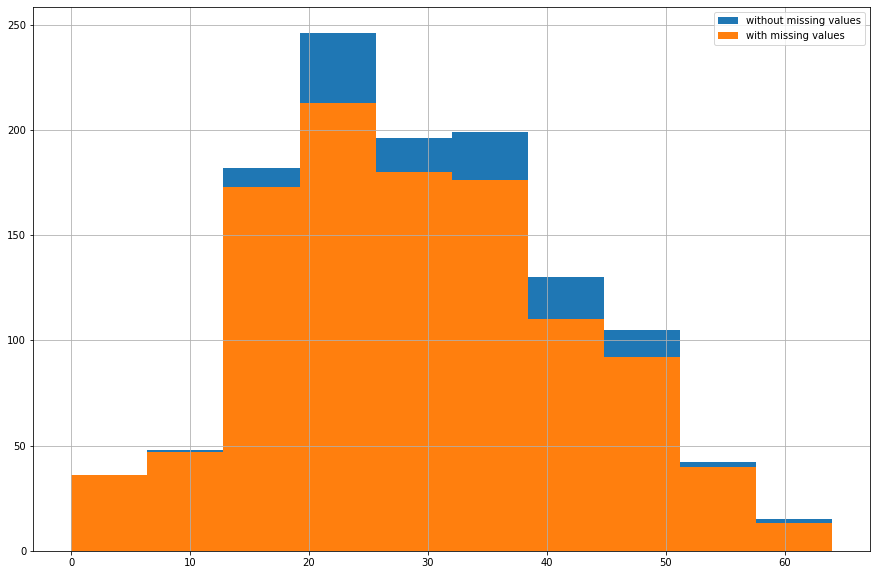

In [55]:
test_df_new['Number_Weeks_Used'].hist(figsize=(15,10))
test_df['Number_Weeks_Used'].hist()
plt.legend(['without missing values','with missing values'])


Observations:
1. We can see that the missing value imputation has increased the frequency of  a range of values and not just the frequency of the mode(20).

## Exploratory Data Analysis

#### Univariate Analysis

In [57]:
for col in test_df_new.drop(['ID'],axis=1).columns:
  if test_df_new[col].nunique() < 30:
    print(f"Values counts for column {col}:")
    print(test_df_new[col].value_counts())
    print('='*50+"\n")

Values counts for column Crop_Type:
0    966
1    233
Name: Crop_Type, dtype: int64

Values counts for column Soil_Type:
0    653
1    546
Name: Soil_Type, dtype: int64

Values counts for column Pesticide_Use_Category:
2    695
3    482
1     22
Name: Pesticide_Use_Category, dtype: int64

Values counts for column Number_Doses_Week:
20    293
40    166
30    162
10    156
15     99
5      70
60     62
50     50
25     48
35     28
0      22
45     14
80     10
55      7
70      6
65      3
90      2
75      1
Name: Number_Doses_Week, dtype: int64

Values counts for column Season:
2    619
1    361
3    219
Name: Season, dtype: int64



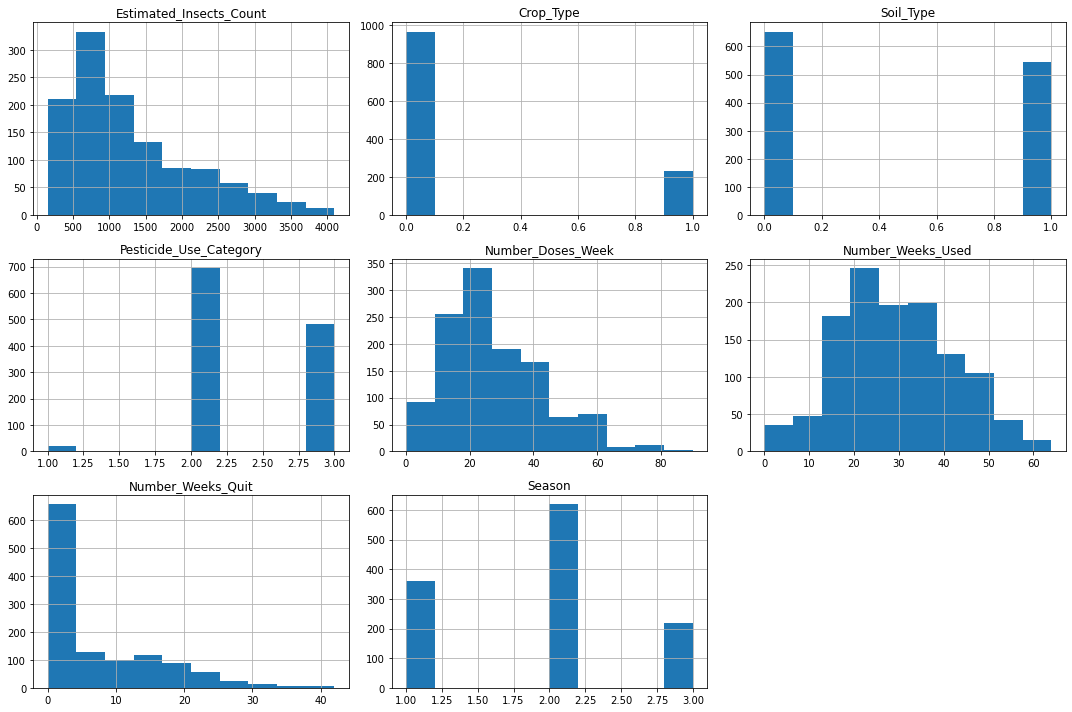

In [58]:
test_df_new.hist(figsize=(15,10))
plt.tight_layout()

Observations:
1. The Estimated_Insects_Count, Number_Doses_Week and Number_Weeks_Quit show positing skewness.
2. Number_Weeks_Used shows a slight skew.
3. There are approximately 3.5 times data in Crop_Type = 0 than in Crop_Type=1 in this dataset.
4. The Soil_Type 0 and 1 are almost equally distributed in the dataset.
5. The occurance of category 1 in Pesticide_Use_Category is very low in the dataset.Category 2 is the most occuring category in the dataset
6. The most frequent category in 'Season' variable is '2' and the most least is '3'.

### Multi Variate Analysis

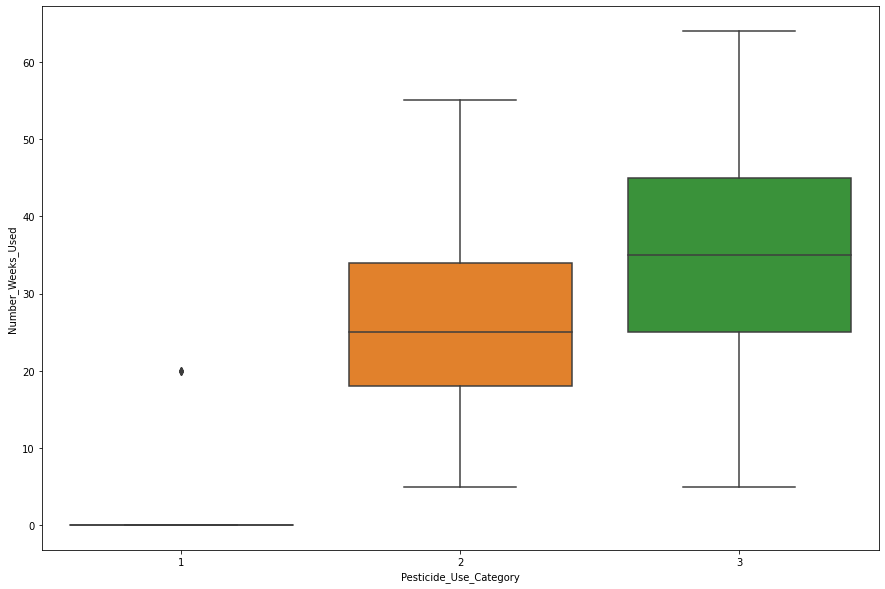

In [63]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pesticide_Use_Category', y= 'Number_Weeks_Used' ,data=test_df_new)

Observations:
1. The Number_Weeks_Used is increasing for Pesticide_Use_Category = 3

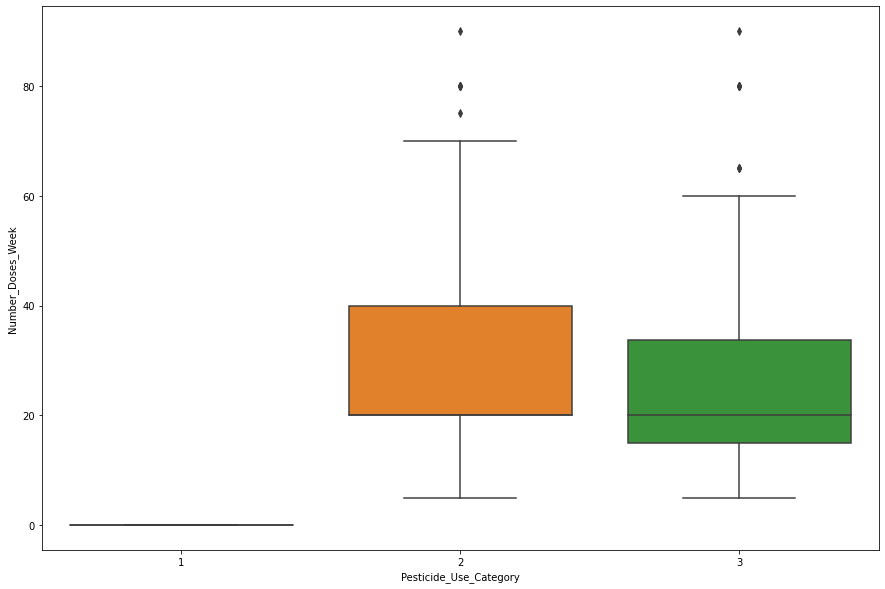

In [64]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pesticide_Use_Category', y= 'Number_Doses_Week',data=test_df_new)


Observations:
1. The Number_Doses_Week is reduced for crops that are using Pesticides currently in the test set.

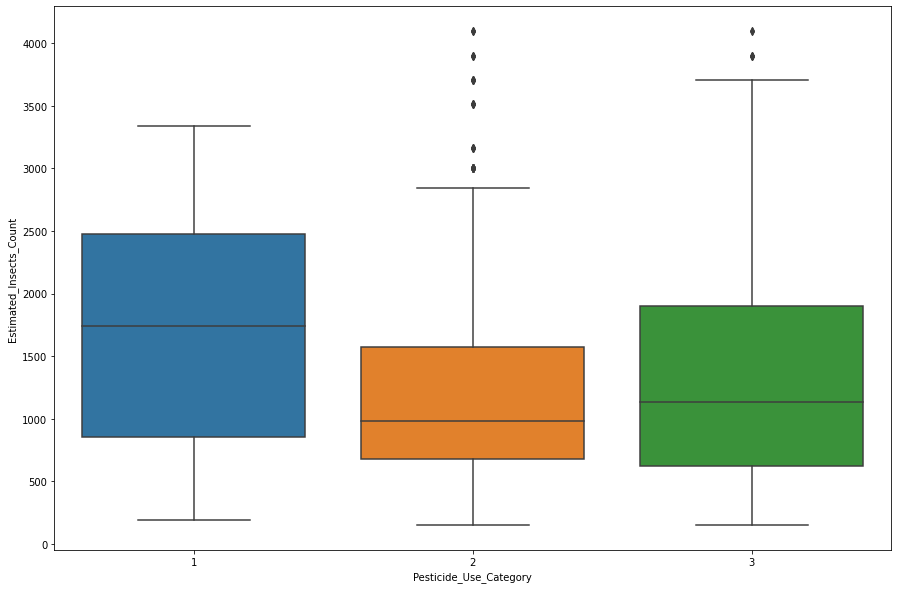

In [66]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pesticide_Use_Category', y= 'Estimated_Insects_Count' ,data=test_df_new)

Observations:
1. Some records show that there is an increased Estimated_Insects_Count in crops where Pesticides are currently being used.

## Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2ae353780>,
      dtype=object)

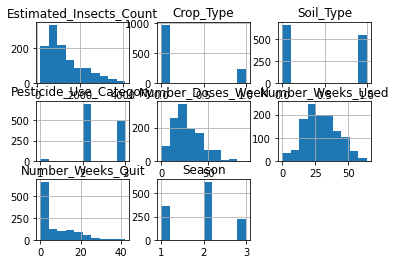

In [67]:
test_df_new.hist()
plt.show()

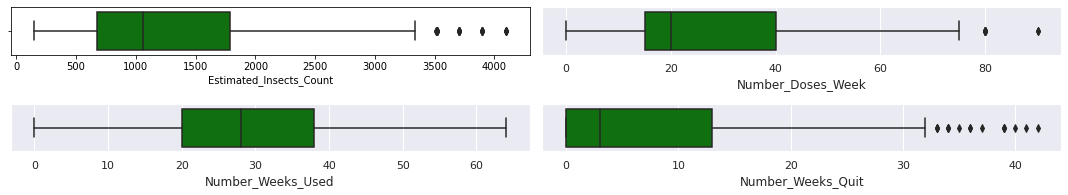

In [68]:
columns = ['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Used','Number_Weeks_Quit']

plt.figure(figsize=(15, 40))
for i in range(0,len(columns)):
  plt.subplot(30,2,i+1)
  sns.set(font_scale = 1)
  sns.boxplot(test_df_new[columns[i]], color='green')
  plt.tight_layout()


Observations:
1. There are some outliers in the Estimated_Insects_Count, Number_Doses_Week and Number_Weeks_Quit.

### Handling Outliers

In [70]:
zf = np.abs(zscore(test_df_new.drop(['ID'], axis=1)))

In [71]:
threshold = 3
test_df_no_out = test_df_new[(zf < threshold).all(axis=1)]
print(f"{round((test_df_new.shape[0] - test_df_no_out.shape[0])/ test_df_new.shape[0]*100)}% data removed as outliers.")

3% data removed as outliers.


Observations:
1. Although its just 3%, there are chances of losing some natural outliers. For eg, in training data the entire target category 2 got removed as outliers.
2. So I will predict the output twice. Once with outliers and another without outliers.

In [73]:
test_df_new.shape

(1199, 9)

In [74]:
test_df_no_out.shape

(1160, 9)

### correlation

Correlation of test dataset with outliers

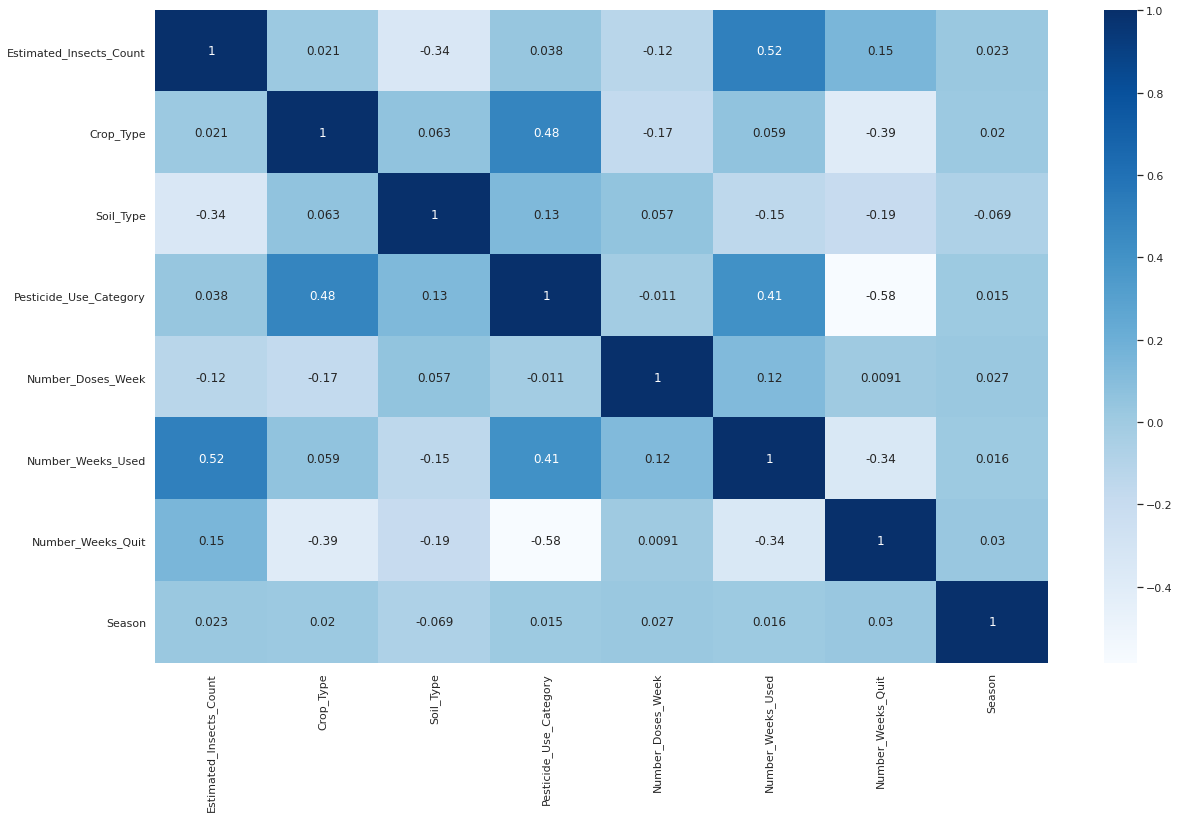

In [76]:
plt.figure(figsize=(20,12))
corr = test_df_new.corr()
sns.heatmap(corr,cmap='Blues', annot=True)

Correlation of test dataset without outliers

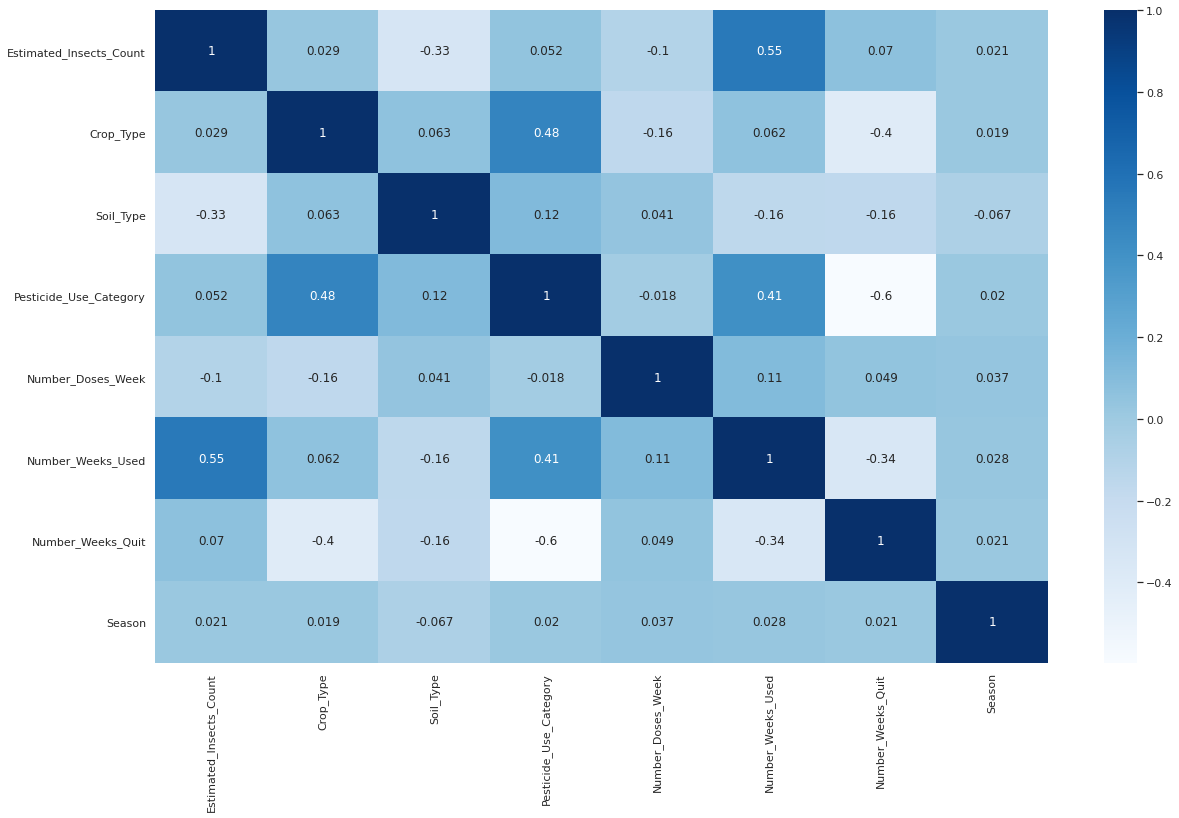

In [75]:
plt.figure(figsize=(20,12))
corr = test_df_no_out.corr()
sns.heatmap(corr,cmap='Blues', annot=True)

Observations:
1. In both datasets, there are no multicorrelations.

### Loading the model pipeline

In [77]:
#mod_pipe = joblib.load('./models/agriculture_model.obj')  # local system
mod_pipe = joblib.load('/content/agriculture_model.obj')  # colab
mod_pipe

Pipeline(memory=None,
         steps=[('pre_process',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('drop_columns', 'drop',
                                                  ['ID']),
                                                 ('power_transform',
                                                  PowerTransformer(copy=True,
                                                                   method='yeo-johnson',
                                                                   standardize=True),
                                                  ['Estimated_Insects_Count',
                                                   'Number_Doses_Week',
                                                   'Number_Weeks_Quit']),
                                                 ('min_max_scale',
         

### Making predictions

In [90]:
#Predicting for test set with outliers
predictions_with_outliers = mod_pipe.predict(test_df_new)

In [91]:
#Predicting for test set without outliers
predictions_without_outliers = mod_pipe.predict(test_df_no_out)

#### Building a dataframe for the predictions and verifying the values frequencies

In [92]:
predictions_with_outliers = pd.DataFrame(predictions_with_outliers, columns=['Predictions'])
predictions_with_outliers['ID'] = test_df_new['ID']
predictions_with_outliers.head()

,Predictions,ID
0,0,F00000002
1,0,F00000007
2,0,F00000011
3,0,F00000013
4,0,F00000014


In [93]:
predictions_with_outliers['Predictions'].value_counts()

0    977
1    210
2     12
Name: Predictions, dtype: int64

In [94]:
predictions_without_outliers = pd.DataFrame(predictions_without_outliers, columns=['Predictions'])
predictions_without_outliers['ID'] = test_df_no_out['ID']
predictions_without_outliers.head()

,Predictions,ID
0,0,F00000002
1,0,F00000007
2,0,F00000011
3,0,F00000013
4,0,F00000014


In [95]:
predictions_without_outliers['Predictions'].value_counts()

0    952
1    196
2     12
Name: Predictions, dtype: int64

### Saving Test set predictions

In [97]:
#local system
#predictions_with_outliers.to_csv('./data/agriculture_predictions.csv',sep=',')
#predictions_without_outliers.to_csv('./data/agriculture_no_outlier_predictions.csv',sep=',')

# Google Colab
predictions_with_outliers.to_csv('/content/agriculture_predictions.csv',sep=',')
predictions_without_outliers.to_csv('/content/agriculture_no_outlier_predictions.csv',sep=',')